# Task 1) Data Collection and Preparation

Following datasets have been sourced and examined:

- "philadelphia_2018.csv": As provided by the team assignment description
- "weather_hourly_philadelphia.csv": As provided by the team assignment description
- "indego-stations-2022-10-01.csv": Sourced from https://www.rideindego.com/about/data/, contains additional, historical information on all Indego stations as of 2022-10-01
- "station_status_20221210_171330.json": Sourced from http://www.rideindego.com/stations/json/ (through https://www.rideindego.com/about/data/), contains additional, live data (in this case a snapshot from 2022-12-10 17:13:30) on all active Indego stations

---

**IMPORTANT**

There are few failing script cells that are still important for the data preparation reasoning process due to their error message.  If it is necessary to disable those failing cells (e.g. because your frontend stops the entire execution at failing cells), you can set the variable EXECUTE_FAILING_CELLS to False in the next cell. By default, it is set to True. By default, it is set to False (True can be for example used with the "runtools"-extension, because it has an option for executing all cells and ignoring errors).

Furthermore, the third-party-package "geopy" is required.

In [1]:
# Import required modules that are used throughout the whole data preparation task
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as pltptc
import seaborn as sns
import datetime as dt
import json
from geopy.geocoders import ArcGIS, Nominatim
import geopy.distance

# Global settings

# Execute failing cells?
EXECUTE_FAILING_CELLS = False

# Disable display limit for DataFrame-columns
pd.set_option("display.max_columns", None)

# Disable limit for printed pandas dataframe rows (optionally, only for testing)
#np.set_printoptions(threshold=np.inf) 

# Use inline plots in this notebook
%matplotlib inline

## Examination: philadelphia_2018.csv

Import "philadelphia_2018.csv" dataset with given data types from task PDF:

In [2]:
# Read column names
pd.read_csv("data/philadelphia_2018.csv", nrows=0)

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name


In [3]:
# Import CSV with Pandas using the given data types from the task PDF
if EXECUTE_FAILING_CELLS:
    rentals_df = pd.read_csv("data/philadelphia_2018.csv",
                        dtype={"start_station_id":"int",
                               "end_station_id":"int",
                               "start_station_name":"str",
                               "end_station_name":"str",
                               "bike_id":"int",
                               "user_type":"str"
                              },
                        parse_dates=["start_time","end_time"])

ValueError: invalid literal for int() with base 10: 'delete me'

Error occurs while importing the dataset: "ValueError: invalid literal for int() with base 10: 'delete me'"  
=> Faulty, alphabetical values (as opposed to assumed int-datatype) in field "bike_id"  
=> Change datatype for field "bike_id" first of all to string to handle the wrong values:

In [4]:
# Import CSV with Pandas using the given data types from the task PDF
rentals_df = pd.read_csv("data/philadelphia_2018.csv",
                        dtype={"start_station_id":"int",
                               "end_station_id":"int",
                               "bike_id":"str", # Change data type to string to handle the wrong values
                               "user_type":"str",
                               "start_station_name":"str",
                               "end_station_name":"str"},
                        parse_dates=["start_time","end_time"])

In [5]:
rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671818 entries, 0 to 671817
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   start_time          671818 non-null  datetime64[ns]
 1   end_time            671818 non-null  datetime64[ns]
 2   start_station_id    671818 non-null  int32         
 3   end_station_id      671818 non-null  int32         
 4   bike_id             671818 non-null  object        
 5   user_type           671818 non-null  object        
 6   start_station_name  671818 non-null  object        
 7   end_station_name    671818 non-null  object        
dtypes: datetime64[ns](2), int32(2), object(4)
memory usage: 35.9+ MB


## Examine variables "start_time" and "end_time":

### Summary

| **Area** | **Findings** |  |  |  |
|:---|:---|---|---|---|
| **Relevance** | Variables are meaningful from a domain perspective (include time information for each trip) |  |  |  |
| **Datatype/Format consistency** | Variables are consistent (datetime format continuously used) |  |  |  |
| **Faulty records** | Some faulty records with "end_time" > "start_time" were deleted; otherwise the records look good (min/max values reasonable; "start_time" includes data from 2018-01-01 to 2018-12-31, "end_time" has single entries for 2019 which belong to trips that started in 2018) and the trip length is >= 1 as stated on the [Indego data site](https://www.rideindego.com/about/data/) |  |  |  |
| **Missing Data** | No Missing Data (671,818 entries for each "start_time" and "end_time" from 671,818 total count) |  |  |  |
| **Outliers** | No Outliers (records only for 2018 as expected) |  |  |  |

### Derived variables

| **Name** | **Type (dtype)** | **Purpose** |
|:---|:---|:---|
| trip_length | Integer (int32) | Trip length in minutes calculated by ("start_time" - "end_time") |
| start_time_hourly | DateTime (datetime64) | Replication of the timestamp with minutes set to 0 |
| hour | Integer (int32) | Describes the hour on which the trip has started |
| weekday | Integer (int32) | Describes the weekday on which the trip has started |
| weekday_name | String (object) | Describes the weekday name on which the trip has started |
| month | Integer (int32) | Describes the month on which the trip has started |
| month_name | String (object) | Describes the month name on which the trip has started |
| season | String (object) | The season on which the trip has started (assignment based on the [meteorological seasons](https://www.ncei.noaa.gov/news/meteorological-versus-astronomical-seasons) |
| is_weekend | Boolean (bool) | Describes if the trip started on the weekend |
| is_holiday | Boolean (bool) | Describes if the trip started on a holiday |

### Preparation steps

Get an initial overall view on the variables:

In [6]:
rentals_df[["start_time","end_time"]].describe(datetime_is_numeric=True)

,start_time,end_time
count,671818,671818
mean,2018-07-11 19:25:14.331202816,2018-07-11 19:47:51.167875840
min,2018-01-01 00:24:00,2018-01-01 00:42:00
25%,2018-05-08 14:32:00,2018-05-08 14:56:00
50%,2018-07-14 16:08:00,2018-07-14 16:36:00
75%,2018-09-19 19:28:00,2018-09-19 19:46:00
max,2018-12-31 23:39:00,2019-01-02 10:10:00


Row count for both variables: 671,818 of total 671,818 rows.  
Check for rows that have entries for 2019 in the "end_time"-column, as the dataset should only return entries for 2018:

In [7]:
rentals_df.loc[rentals_df["end_time"].dt.year == 2019]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name
669338,2018-12-28 10:25:00,2019-01-02 10:10:00,3121,3000,15067,Indego30,27th & Girard,Virtual Station
670616,2018-12-30 04:43:00,2019-01-01 11:25:00,3154,3000,5279,Day Pass,12th & Callowhill,Virtual Station
671639,2018-12-31 12:25:00,2019-01-01 11:16:00,3010,3086,5308,Indego30,15th & Spruce,Broad & Christian
671729,2018-12-31 15:43:00,2019-01-01 11:16:00,3010,3086,2472,Indego365,15th & Spruce,Broad & Christian
671744,2018-12-31 16:29:00,2019-01-01 11:15:00,3032,3086,11879,Indego30,23rd & South,Broad & Christian
671812,2018-12-31 23:17:00,2019-01-01 00:04:00,3037,3037,11794,Day Pass,Pennsylvania Convention Center,Pennsylvania Convention Center
671813,2018-12-31 23:18:00,2019-01-01 00:04:00,3037,3037,14519,Day Pass,Pennsylvania Convention Center,Pennsylvania Convention Center
671814,2018-12-31 23:25:00,2019-01-01 00:06:00,3168,3168,11891,Indego30,20th & Sansom,20th & Sansom
671815,2018-12-31 23:26:00,2019-01-01 06:44:00,3026,3026,5410,Indego30,2nd & South,2nd & South


Said entries regarding "end_time" are valid since the "start_time" goes back to 2018.  
Remark: Suspect records with "Virtual Station" will be handled in the examination section for the station name variables.  

Derive length of trip and check for trips with an invalid length (trip length less/equal zero minutes by calculating the difference between start time and end time):

In [8]:
# Derive length of trip as column "trip_length"
rentals_df["trip_length"] = ((rentals_df["end_time"]-rentals_df["start_time"]).dt.total_seconds() / 60).astype(int)

# Return records with trip length less/equal zero minutes
rentals_df.loc[rentals_df["trip_length"] <= 0]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,trip_length
603513,2018-11-04 01:21:00,2018-11-04 01:20:00,3011,3009,05262,Indego30,38th & Powelton,33rd & Market,-1
603524,2018-11-04 01:42:00,2018-11-04 01:14:00,3190,3108,03718,Indego30,17th & Locust,15th & Market,-28
603527,2018-11-04 01:47:00,2018-11-04 01:00:00,3167,3015,14540,Day Pass,12th & Chestnut,"4th & Walnut, NPS",-47
603529,2018-11-04 01:48:00,2018-11-04 01:00:00,3010,3099,03565,Indego30,15th & Spruce,4th & Washington,-48
603530,2018-11-04 01:49:00,2018-11-04 01:00:00,3167,3015,11895,Day Pass,12th & Chestnut,"4th & Walnut, NPS",-49
603532,2018-11-04 01:51:00,2018-11-04 01:00:00,3167,3015,14487,Day Pass,12th & Chestnut,"4th & Walnut, NPS",-51
603536,2018-11-04 01:54:00,2018-11-04 01:00:00,3086,3052,03448,Indego365,Broad & Christian,9th & Locust,-54


These records have a negative trip length (i.e. start time is later than end time) which doesn't make sense.  
The values of the other columns look reasonable and it might be that those 7 records: 
- have the columns mixed up ("end_time" is "start_time" and vice versa)
- have been subject to a system test, since they also end at a similar point in time
- have a time conversion error in "end_time" with the 12h/24h format (1am => 13h)

It is nevertheless decided to drop these 7 rows since our current total row count of 678,818 rows is high enough to neglect them.

In [9]:
# Delete records 
rentals_df = rentals_df.drop(rentals_df[rentals_df["trip_length"] <= 0].index)

# Verify deletion of invalid records
rentals_df.loc[rentals_df["trip_length"] <= 0] 

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,trip_length


#### Further analysis of trip length for indication of outlier-like records

Records with trip lengths in terms of zero and negative lengths have been just deleted. Additionally, it will be investigated if there are records with implausible trip lengths from a domain perspective:

- Very short trips with a length of 1 minute since it seems unlikely that one would rent a bike for such a short trip
- Comparatively very long trips in terms of outliers that might indicate faulty records

A boxplot is created in order to get a first insight into the distribution of trip lengths across the entire rental dataset.

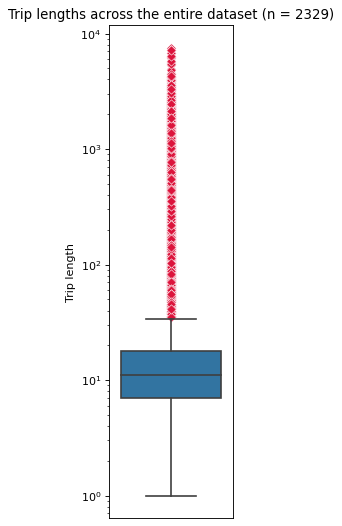

In [10]:
# Setup plot
fig = plt.figure(figsize = (2, 8), dpi = 80)

# Calculate 25 %- and 75 %-quantiles
q1, q3 = np.quantile(rentals_df["trip_length"].values, [0.25, 0.75])

counts = rentals_df['bike_id'].value_counts().reset_index(name='count')

# Calculate outlier thresholds by using standard IQR*1.5-method
wlo = q1-(q3-q1)*1.5
wlo = 0 if wlo < 0 else wlo  # Set 0 (minimum plausible trip length) if mathematically negative
whigh = q3+(q3-q1)*1.5

# Calculate outliers 
outliers = rentals_df["trip_length"].values[(rentals_df["trip_length"].values > whigh) | (rentals_df["trip_length"].values < wlo)]

# Display boxplot
vio = sns.boxplot(data=rentals_df, y='trip_length', showfliers = False)#, cut=0)
vio.tick_params(bottom=False)
vio.set(title="Trip lengths across the entire dataset (n = "+ str(len(counts)) + ")", ylabel="Trip length")

# Display scatterplot with outliers
sns.scatterplot(y=outliers, x=0, marker='D', color='crimson')

# Set log scale
plt.gca().set_yscale('log')
plt.show()

Note that the outliers are calculated using the canonical IQR*1.5-rule.  

It is interesting that although the outliers are spreading over two orders of magnitudes in contrast to the third quartile, there are no outliers on the lower boundary which is the result of the dataset being right skewed in terms of the trip length.  
This makes sense from a domain perspective as the majority of trips that are done with a locally based bike sharing service like Indego in Philadelphia are likely such ones for getting quickly from bike station A to bike station B within the city.  

Now, trips with a trip length of 1 minute are examined since they are from a domain perspective not plausible. While it could be that somebody in rush is using a bike for a really short trip (e.g. under time pressure), it seems unlikely that this is a typical case considering that the customer needs to calculate additional time to unlock the bike, lock it at the target station and be aware for for possible problems with the bike.

In [11]:
# Reset maximum row display (in case it was modified before for testing)
pd.reset_option('^display.', silent=True)

# Display trips with trip length of 1
rentals_df.loc[(rentals_df["trip_length"] == 1)]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,trip_length
28,2018-01-01 08:40:00,2018-01-01 08:41:00,3023,3023,11786,Indego30,Rittenhouse Square,Rittenhouse Square,1
46,2018-01-01 10:49:00,2018-01-01 10:50:00,3101,3101,3439,Indego30,11th & South,11th & South,1
101,2018-01-01 14:55:00,2018-01-01 14:56:00,3112,3112,11763,Walk-up,48th & Spruce,48th & Spruce,1
148,2018-01-01 17:40:00,2018-01-01 17:41:00,3045,3045,11818,Walk-up,13th & Locust,13th & Locust,1
156,2018-01-01 18:11:00,2018-01-01 18:12:00,3007,3007,3309,Indego365,"11th & Pine, Kahn Park","11th & Pine, Kahn Park",1
...,...,...,...,...,...,...,...,...,...
671425,2018-12-31 08:30:00,2018-12-31 08:31:00,3054,3054,14478,Indego30,Rodin Museum,Rodin Museum,1
671434,2018-12-31 08:37:00,2018-12-31 08:38:00,3098,3098,2645,Indego365,10th & Federal,10th & Federal,1
671643,2018-12-31 12:29:00,2018-12-31 12:30:00,3155,3155,11942,Indego30,7th & Fitzwater,7th & Fitzwater,1
671680,2018-12-31 13:41:00,2018-12-31 13:42:00,3066,3066,11884,Indego30,19th & Lombard,19th & Lombard,1


It stands out that the IDs of the start and end station are the same for some of the sampled trips.  
This might be a hint that such short trips with a trip length of 1 minute are not actual trips, but probably trips where bikes were checked out but checked in again at the same station due to a problem.  
This will be examined by checking how much trips are actually ended at the same station.

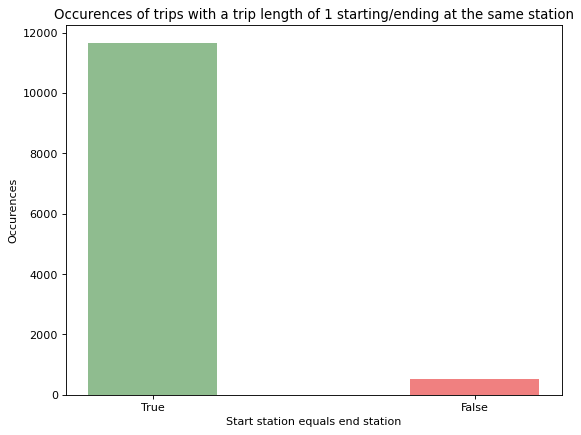

In [12]:
# Derive a helper variable "is_roundtrip" which indicates if a trip started and ended at the same station
rentals_df["is_roundtrip"] = rentals_df["start_station_id"] == rentals_df["end_station_id"]

# Create a grouped dataset that calculates the amount of roundtrips/no roundtrips for all records with a trip length of 1 minute
roundtrip_1_min_df = rentals_df["is_roundtrip"].loc[(rentals_df["trip_length"] == 1)].value_counts().reset_index(name="counts")

# Setup plot
fig = plt.figure(figsize = (8, 6), dpi = 80)

# Plot bar chart with is_roundtrip on x-axis and corresponding counts on y-axis; additional coloring based on values
plt.bar(roundtrip_1_min_df["index"].astype(str),
        roundtrip_1_min_df["counts"],
        width = 0.4,
        color = ["lightcoral" if i == False else "darkseagreen" for i in roundtrip_1_min_df["index"]])
 
plt.xlabel("Start station equals end station")
plt.ylabel("Occurences")
plt.title("Occurences of trips with a trip length of 1 starting/ending at the same station")
plt.show()

This bar chart confirms the described theory: Trips with a trip length of 1 minute seem to be (at least the vast majority) not actual trips but situations where problems at the start station arised (e.g. a physical technical problem with the bike was just discovered after checking it out or the battery of an electronic bike was empty although the app displayed a different battery level).  
In order to further verify this theory, trips with a trip length of up to 4 minutes are also reviewed:

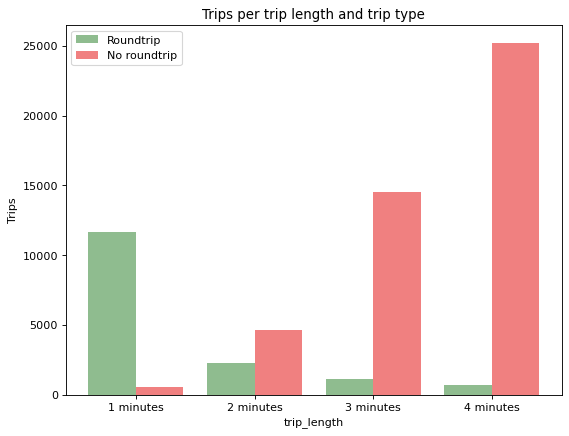

In [13]:
# Group dataset based on "trip_length" and "is_roundtrip" and calculate the resulting records
roundtrip_extended_df = rentals_df.groupby(["trip_length", "is_roundtrip"]).agg(Count=("start_time","size")).reset_index()

# Define up to which trip length the data should be calculated
TRIP_LENGTH = 4

# Filter dataset only for defined trip length
roundtrip_extended_df = roundtrip_extended_df.loc[roundtrip_extended_df["trip_length"] <= TRIP_LENGTH]

# Create labels flexible based on the defined trip length
x_tick_labels = [(str(t)+" minutes") for t in range(1, TRIP_LENGTH+1)]

# Define amount of categories in x-axis based on given labels
x_axis_count = np.arange(len(x_tick_labels))

# Setup plot
fig = plt.figure(figsize=(8, 6), dpi=80)

# Display plot
plt.bar(x_axis_count-0.2, roundtrip_extended_df["Count"].loc[roundtrip_extended_df["is_roundtrip"] == True].values, 0.4, label="Roundtrip", color="darkseagreen")
plt.bar(x_axis_count+0.2, roundtrip_extended_df["Count"].loc[roundtrip_extended_df["is_roundtrip"] == False].values, 0.4, label="No roundtrip", color="lightcoral")

plt.xticks(x_axis_count, x_tick_labels)
plt.xlabel("trip_length")
plt.ylabel("Trips")
plt.title("Trips per trip length and trip type")
plt.legend()
plt.show()

It can be seen that trips with a trip length of 2 to 4 minutes are less likely to end at the start station which strengthens the explained theory.

However, trips with a trip length of 1 minute are not considered as outliers in the sense that they should be removed from the dataset since they are valuable from a domain perspective in regards of identifying bikes or stations where problems are occuring frequently.  

In regards of trips that were mathematically determined as upper outliers starting at 34.5 minutes it is decided that they also won't be treated as outliers that should be removed from the dataset since it is assumed that those trips are valid because the time itself is plausible (i.e. there is not a plausible limit of time that makes sense since every user does something else with the bike that might required different time demands).  
This might be investigated further in the descriptive analysis, but from a pure data perspective, there is nothing that would indicate faulty records here.

Finally, the variable "is_roundtrip" will be kept since it seems to be provide additional interesting information about the trips.  
The derivation will be nevertheless noted in the examination of "start_station_id" and "stop_station_id" since it is derived from exactly those variables.

Additionally, following further features are derived from "start_time":
- "start_time_hourly": Replication of the timestamp with minutes set to 0
- "hour": Describes the hour on which the trip has started
- "weekday": Describes the weekday on which the trip has started
- "weekday_name": Describes the weekday name on which the trip has started
- "month": Describes the month on which the trip has started
- "month_name": Describes the month name on which the trip has started
- "season": Describes the season on which the trip has started
- "is_weekend": Describes if the trip started on the weekend
- "is_holiday": Describes if the trip started on a holiday

#### Derive "start_time_hourly"

This field might be required during the further analytics tasks for aggregating trips on a daily, hourly basis.

In [14]:
rentals_df["start_time_hourly"] = rentals_df["start_time"].dt.floor("h")

#### Derive "hour"

This field might be required during the further analytics tasks for aggregating on a hourly basis.

In [15]:
rentals_df["hour"] = rentals_df["start_time"].dt.hour

#### Derive "weekday", "weekday_name"

This field might be required during the further analytics tasks for aggregating on a weekday basis.  
"weekday" describes the numerical position of the weekday within a week and "weekday_name" describes the weekday name.

In [16]:
rentals_df["weekday"] = rentals_df["start_time"].dt.dayofweek
rentals_df["weekday_name"] = rentals_df["start_time"].dt.day_name()

It needs to be kept in mind that "end_time" outputs a different weekday when the trip spans over more than one day:

In [17]:
print(rentals_df["weekday"].loc[rentals_df["start_time"].dt.day != rentals_df["end_time"].dt.day].value_counts(), "\n")
print(rentals_df["weekday"].loc[rentals_df["start_time"].dt.day != rentals_df["end_time"].dt.day].count())

5    1027
4     980
3     803
0     782
6     762
2     754
1     709
Name: weekday, dtype: int64 

5817


Overall, there are 5,817 rows where the trip spans over more than one day and the start day/end day is therefore different.  
Although the tendency goes towards the weekend with Friday and Saturday the records are distributed very well over the whole week.
In order to keep the dataset simplistic while simultaneously trying to get as much information out of it as possible, it is decided that the weekday and and all other features described for the derivation will only be derived for "start_time" since we don't expect any valuable information out of this small portion of data that would justify the additional data.  
If nevertheless required in a further task, the derivation might be done additionally.

In [18]:
# Exemplary verification
rentals_df[["start_time", "weekday", "weekday_name"]].sample(10)

,start_time,weekday,weekday_name
592169,2018-10-29 17:40:00,0,Monday
577327,2018-10-21 20:17:00,6,Sunday
236159,2018-06-06 17:43:00,2,Wednesday
189694,2018-05-18 08:33:00,4,Friday
527497,2018-09-30 12:41:00,6,Sunday
162137,2018-05-06 07:29:00,6,Sunday
498715,2018-09-17 20:37:00,0,Monday
428454,2018-08-18 17:34:00,5,Saturday
433943,2018-08-21 13:48:00,1,Tuesday
211919,2018-05-28 07:27:00,0,Monday


#### Derive "month", "month_name"

This field might be required during the further analytics tasks for aggregating on a weekday basis.  
"month" describes the numerical position of the weekday within a week and "month_name" describes the weekday name.

In [19]:
rentals_df["month"] = rentals_df["start_time"].dt.month
rentals_df["month_name"] = rentals_df["start_time"].dt.month_name()

In [20]:
# Exemplary verification
rentals_df[["start_time", "month", "month_name"]].sample(10)

,start_time,month,month_name
466475,2018-09-03 12:18:00,9,September
496110,2018-09-16 19:29:00,9,September
533667,2018-10-02 17:37:00,10,October
661805,2018-12-18 21:30:00,12,December
443104,2018-08-24 16:51:00,8,August
589924,2018-10-28 13:00:00,10,October
502493,2018-09-19 13:56:00,9,September
51833,2018-02-20 18:56:00,2,February
123457,2018-04-16 10:56:00,4,April
393602,2018-08-05 17:08:00,8,August


#### Derive "season"

This field might be required during the further analytics tasks for separating records based on the season.

In [21]:
# Define periods of time for all four meteorological seasons (source: https://www.ncei.noaa.gov/news/meteorological-versus-astronomical-seasons)
season_conditions = [((rentals_df["start_time"] >= pd.to_datetime("2018-01-01")) & (rentals_df["start_time"] < pd.to_datetime("2018-03-01"))) | (rentals_df["start_time"] >= pd.to_datetime("2018-12-01")),
             (rentals_df["start_time"] >= pd.to_datetime("2018-03-01")) & (rentals_df["start_time"] < pd.to_datetime("2018-06-01")),
             (rentals_df["start_time"] >= pd.to_datetime("2018-06-01")) & (rentals_df["start_time"] < pd.to_datetime("2018-09-01")),
             (rentals_df["start_time"] >= pd.to_datetime("2018-09-01")) & (rentals_df["start_time"] < pd.to_datetime("2018-12-01"))]

# Define labels for all four meteorological seasons
season_values = ["Winter",
          "Spring",
          "Summer",
          "Autumn"]

# Assign seasons accordingly to all records with column "season"
rentals_df.loc[:, "season"] = np.select(season_conditions, season_values)

In [22]:
# Exemplary verification (test period of time for autumn)
print("Assignment of autumn to dataset:\n")
print(rentals_df["start_time"].loc[rentals_df["season"] == "Autumn"].describe(datetime_is_numeric=True))

# Exemplary verification
rentals_df[["start_time", "season"]].sample(10)

Assignment of autumn to dataset:

count                           178640
mean     2018-10-11 17:04:38.585199360
min                2018-09-01 00:05:00
25%                2018-09-20 16:39:00
50%                2018-10-09 17:00:00
75%                2018-10-31 08:04:00
max                2018-11-30 23:57:00
Name: start_time, dtype: object


,start_time,season
406730,2018-08-10 09:14:00,Summer
170288,2018-05-09 09:13:00,Spring
275561,2018-06-21 10:25:00,Summer
507311,2018-09-21 00:17:00,Autumn
500295,2018-09-18 17:36:00,Autumn
356968,2018-07-22 16:36:00,Summer
324172,2018-07-10 17:53:00,Summer
220817,2018-05-31 11:09:00,Spring
401807,2018-08-08 16:49:00,Summer
351247,2018-07-20 07:21:00,Summer


#### Derive "is_weekend"

This field might be required during the further analytics tasks for separating records based on business days and weekends.

In [23]:
# Describe if the given weekday belongs to the weekend (= is Saturday or Sunday)
rentals_df["is_weekend"] = rentals_df["weekday_name"].isin(["Saturday", "Sunday"])

In [24]:
# Exemplary verification
rentals_df[["weekday_name", "is_weekend"]].sample(10)

,weekday_name,is_weekend
309220,Thursday,False
560141,Saturday,True
280513,Saturday,True
257147,Thursday,False
46142,Friday,False
466751,Monday,False
303202,Monday,False
280550,Saturday,True
568497,Wednesday,False
353101,Friday,False


#### Derive "is_holiday"

This field might be required during the further analytics tasks for separating records based on holidays.

Following sources have been reviewed for defining the holidays in Philadelphia (PA):

OfficeHolidays (2023): used, archived version from January 30, 2023: https://web.archive.org/web/20230130200413/https://www.officeholidays.com/countries/usa/pennsylvania/2018  
original source: https://www.officeholidays.com/countries/usa/pennsylvania/2018

LeaveBoard (2023): used, archived version from November 30, 2022:  
https://web.archive.org/web/20221130103334/https://leaveboard.com/public-holidays/united-states-pennsylvania-public-holidays-2018/  
original source: https://leaveboard.com/public-holidays/united-states-pennsylvania-public-holidays-2018/

Note for OfficeHolidays: Only "National Holidays" and "Regional Holidays" have been used, which equals the data on LeaveBoard.

In [25]:
holiday_list = {"2018-01-01": "New Year's Day",
                "2018-01-15": "Martin Luther King Jr. Day",
                "2018-02-19": "President's Day",
                "2018-05-28": "Memorial Day",
                "2018-07-04": "Independence Day",
                "2018-09-03": "Labor Day",
                "2018-10-08": "Columbus Day",
                "2018-11-12": "Veterans Day",
                "2018-11-22": "Thanksgiving",
                "2018-11-23": "Day after Thanksgiving",
                "2018-12-25": "Christmas Day"}

In [26]:
rentals_df["is_holiday"] = rentals_df["start_time"].dt.strftime('%Y-%m-%d').isin(list(holiday_list.keys()))

In [27]:
# Verification
rentals_df.loc[rentals_df["is_holiday"] == True]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,trip_length,is_roundtrip,start_time_hourly,hour,weekday,weekday_name,month,month_name,season,is_weekend,is_holiday
0,2018-01-01 00:24:00,2018-01-01 00:42:00,3124,3073,3708,Indego30,Race Street Pier,9th & Spring Garden,18,False,2018-01-01 00:00:00,0,0,Monday,1,January,Winter,False,True
1,2018-01-01 00:38:00,2018-01-01 10:10:00,3023,3066,3288,Indego365,Rittenhouse Square,19th & Lombard,572,False,2018-01-01 00:00:00,0,0,Monday,1,January,Winter,False,True
2,2018-01-01 00:48:00,2018-01-01 01:10:00,3026,3023,11735,Indego30,2nd & South,Rittenhouse Square,22,False,2018-01-01 00:00:00,0,0,Monday,1,January,Winter,False,True
3,2018-01-01 01:03:00,2018-01-01 01:24:00,3045,3037,5202,Indego30,13th & Locust,Pennsylvania Convention Center,21,False,2018-01-01 01:00:00,1,0,Monday,1,January,Winter,False,True
4,2018-01-01 01:05:00,2018-01-01 01:09:00,3115,3058,5142,Indego30,"19th & Girard, PTTI",20th & Fairmount,4,False,2018-01-01 01:00:00,1,0,Monday,1,January,Winter,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667528,2018-12-25 23:26:00,2018-12-26 00:15:00,3056,3104,2555,Indego30,Broad & Oxford,34th & Mantua,49,False,2018-12-25 23:00:00,23,1,Tuesday,12,December,Winter,False,True
667529,2018-12-25 23:27:00,2018-12-25 23:30:00,3165,3156,3681,Indego30,24th & Race SRT,20th & Market,3,False,2018-12-25 23:00:00,23,1,Tuesday,12,December,Winter,False,True
667530,2018-12-25 23:32:00,2018-12-25 23:52:00,3068,3000,2689,Indego30,Broad & Federal,Virtual Station,20,False,2018-12-25 23:00:00,23,1,Tuesday,12,December,Winter,False,True
667531,2018-12-25 23:35:00,2018-12-26 00:09:00,3025,3012,3403,Indego30,11th & Washington,21st & Catharine,34,False,2018-12-25 23:00:00,23,1,Tuesday,12,December,Winter,False,True


In [28]:
rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 671811 entries, 0 to 671817
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   start_time          671811 non-null  datetime64[ns]
 1   end_time            671811 non-null  datetime64[ns]
 2   start_station_id    671811 non-null  int32         
 3   end_station_id      671811 non-null  int32         
 4   bike_id             671811 non-null  object        
 5   user_type           671811 non-null  object        
 6   start_station_name  671811 non-null  object        
 7   end_station_name    671811 non-null  object        
 8   trip_length         671811 non-null  int32         
 9   is_roundtrip        671811 non-null  bool          
 10  start_time_hourly   671811 non-null  datetime64[ns]
 11  hour                671811 non-null  int64         
 12  weekday             671811 non-null  int64         
 13  weekday_name        671811 no

New row count: 671,811

## Examine variables "start_station_id" and "end_station_id":

### Summary

| **Area** | **Findings** |  |  |  |
|:---|:---|---|---|---|
| **Relevance** | Variables are meaningful from a domain perspective (include stations involved for each trip) |  |  |  |
| **Datatype/Format consistency** | Variables are consistent (numeric values only as expected) |  |  |  |
| **Faulty records** | Some IDs seem conspicuous (9xxxx format) and don't have a station name assigned => verification against station data in another step |  |  |  |
| **Missing Data** | No Missing Data (671,811 entries for each "start_station_id" and "end_station_id" from 671,811 total count) |  |  |  |
| **Outliers** | No Outliers (categorical data; all records are considered) |  |  |  |

### Derived variables

| **Name** | **Type (dtype)** | **Purpose** |
|:---|:---|:---|
| is_roundtrip | Boolean (bool) | Describes if the trip started and ended at the same station (if "start_station_id" == "end_station_id") - Note: **Derivation took already place in the examination of "start_time" and "end_time"** |

### Preparation steps

Get an initial overall view on the variables:

In [29]:
rentals_df[["start_station_id", "end_station_id"]].describe()

,start_station_id,end_station_id
count,671811.000000,671811.000000
mean,3071.108175,3408.766137
std,452.807059,5432.417920
min,3000.000000,3000.000000
25%,3028.000000,3027.000000
50%,3056.000000,3055.000000
75%,3102.000000,3102.000000
max,90018.000000,90255.000000


Row count for both variables: 671,811 of total 671,811 rows. 
Get an overall insight on the stations by returning all unique IDs:

In [30]:
print("Start station IDs:\n", rentals_df["start_station_id"].unique(), "\nEnd station IDs:\n", rentals_df["end_station_id"].unique())

Start station IDs:
 [ 3124  3023  3026  3045  3115  3046  3098  3055  3056  3021  3160  3154
  3156  3007  3025  3070  3101  3078  3114  3108  3053  3064  3032  3016
  3058  3059  3043  3028  3033  3012  3068  3157  3086  3030  3020  3024
  3169  3161  3017  3011  3168  3049  3052  3072  3100  3102  3010  3019
  3150  3121  3066  3054  3051  3027  3099  3158  3112  3041  3074  3034
  3120  3159  3039  3004  3165  3038  3063  3008  3050  3029  3073  3075
  3040  3153  3006  3036  3022  3069  3104  3170  3062  3071  3163  3067
  3107  3013  3155  3103  3035  3162  3057  3125  3005  3018  3065  3077
  3060  3122  3015  3095  3009  3118  3116  3047  3097  3037  3129  3164
  3117  3093  3031  3110  3088  3106  3061  3096  3152  3123  3113  3119
  3111  3167  3014 90007 90018  3166  3000 90010  3184  3183  3186  3185
  3188  3181  3192  3190  3187  3182] 
End station IDs:
 [ 3073  3066  3023  3037  3058  3000  3072  3158  3155  3110  3007  3022
  3070  3071  3034  3040  3157  3033  3010  302

Noticeable: Most station IDs have an 3xxx format, whereas few station IDs have an 9xxxx format.  
Review those records within the full dataset:

In [31]:
rentals_df.loc[(rentals_df["start_station_id"] > 90000)]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,trip_length,is_roundtrip,start_time_hourly,hour,weekday,weekday_name,month,month_name,season,is_weekend,is_holiday
30629,2018-02-02 11:20:00,2018-02-02 11:21:00,90007,90022,3376,Indego30,90007,90022,1,False,2018-02-02 11:00:00,11,4,Friday,2,February,Winter,False,False
30636,2018-02-02 11:33:00,2018-02-02 11:34:00,90007,90022,5129,Indego30,90007,90022,1,False,2018-02-02 11:00:00,11,4,Friday,2,February,Winter,False,False
30661,2018-02-02 12:04:00,2018-02-02 12:05:00,90007,90022,11837,Indego30,90007,90022,1,False,2018-02-02 12:00:00,12,4,Friday,2,February,Winter,False,False
30666,2018-02-02 12:08:00,2018-02-02 12:09:00,90007,90022,11839,Indego30,90007,90022,1,False,2018-02-02 12:00:00,12,4,Friday,2,February,Winter,False,False
33183,2018-02-05 11:43:00,2018-02-05 11:44:00,90007,90022,2601,Indego30,90007,90022,1,False,2018-02-05 11:00:00,11,0,Monday,2,February,Winter,False,False
52930,2018-02-21 11:36:00,2018-02-21 11:37:00,90018,90022,5267,Indego30,90018,90022,1,False,2018-02-21 11:00:00,11,2,Wednesday,2,February,Winter,False,False
73191,2018-03-11 12:53:00,2018-03-11 12:54:00,90007,90022,5174,Indego30,90007,90022,1,False,2018-03-11 12:00:00,12,6,Sunday,3,March,Spring,True,False
91633,2018-03-27 12:21:00,2018-03-27 12:22:00,90007,90022,5296,Indego30,90007,90022,1,False,2018-03-27 12:00:00,12,1,Tuesday,3,March,Spring,False,False
103141,2018-04-04 12:04:00,2018-04-04 12:05:00,90007,90022,11037,Indego365,90007,90022,1,False,2018-04-04 12:00:00,12,2,Wednesday,4,April,Spring,False,False
103144,2018-04-04 12:07:00,2018-04-04 12:08:00,90007,90022,5279,Indego365,90007,90022,1,False,2018-04-04 12:00:00,12,2,Wednesday,4,April,Spring,False,False


In [32]:
rentals_df.loc[(rentals_df["end_station_id"] > 90000)]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,trip_length,is_roundtrip,start_time_hourly,hour,weekday,weekday_name,month,month_name,season,is_weekend,is_holiday
362,2018-01-02 09:05:00,2018-01-02 09:16:00,3019,90018,11958,Indego30,6th & Race,90018,11,False,2018-01-02 09:00:00,9,1,Tuesday,1,January,Winter,False,False
1056,2018-01-03 08:38:00,2018-01-03 08:58:00,3102,90018,5309,Indego30,Pennsylvania & Fairmount Perelman Building,90018,20,False,2018-01-03 08:00:00,8,2,Wednesday,1,January,Winter,False,False
2045,2018-01-05 11:27:00,2018-01-05 11:56:00,3068,90018,11924,Indego30,Broad & Federal,90018,29,False,2018-01-05 11:00:00,11,4,Friday,1,January,Winter,False,False
2147,2018-01-05 18:16:00,2018-01-05 18:45:00,3153,90018,5259,Indego30,"Thompson & Palmer, Adaire School",90018,29,False,2018-01-05 18:00:00,18,4,Friday,1,January,Winter,False,False
2679,2018-01-08 08:52:00,2018-01-08 09:07:00,3019,90018,11862,Indego30,6th & Race,90018,15,False,2018-01-08 08:00:00,8,0,Monday,1,January,Winter,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299681,2018-06-30 15:26:00,2018-06-30 15:43:00,3055,90007,3585,IndegoFlex,8th & Market,90007,17,False,2018-06-30 15:00:00,15,5,Saturday,6,June,Summer,True,False
299976,2018-06-30 17:46:00,2018-06-30 17:56:00,3103,90007,5134,Indego30,"27th & Master, Athletic Recreation Center",90007,10,False,2018-06-30 17:00:00,17,5,Saturday,6,June,Summer,True,False
299999,2018-06-30 17:55:00,2018-06-30 20:10:00,3047,90007,11779,Indego30,"Independence Mall, NPS",90007,135,False,2018-06-30 17:00:00,17,5,Saturday,6,June,Summer,True,False
300183,2018-06-30 19:18:00,2018-06-30 19:29:00,3018,90007,2720,Indego30,12th & Filbert,90007,11,False,2018-06-30 19:00:00,19,5,Saturday,6,June,Summer,True,False


It seems that station IDs with a 9xxxx format don't have station names and it can also be noted that when looking at the "start_time" it appears that records for the 9xxxx stations only exist from 2018-01-02 to 2018-06-30.  

Verify station names for station IDs with 9xxxx format:

In [33]:
print(rentals_df["start_station_name"].loc[(rentals_df["start_station_id"] > 90000)].unique())
print(rentals_df["end_station_name"].loc[(rentals_df["end_station_id"] > 90000)].unique())

['90007' '90018' '90010']
['90018' '90007' '90010' '90022' '90001' '90255']


Stations with 9xxxx have no name in the form of a specified street like the 3xxx stations. At this point, the station information data is already pulled in for a quick review of those 9xxxx stations (the detailed examination of the station information data is done later in the data preparation):

In [34]:
# Quick import without types 
stations_df = pd.read_csv("data/indego-stations-2022-10-01.csv")
stations_df.describe()

,Station_ID,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
count,200.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,3133.915000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,87.320686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,3000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3054.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,3118.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,3208.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,3287.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The maximum value for "Station_ID" is 3287 which indicates that there is no information about the 9xxxx stations available.

In order to find out more about the characteristics of those stations, the distribution of records in comparison to the 3xxx stations in the period of time from 2018-01-02 to 2018-06-30 will be investigated.

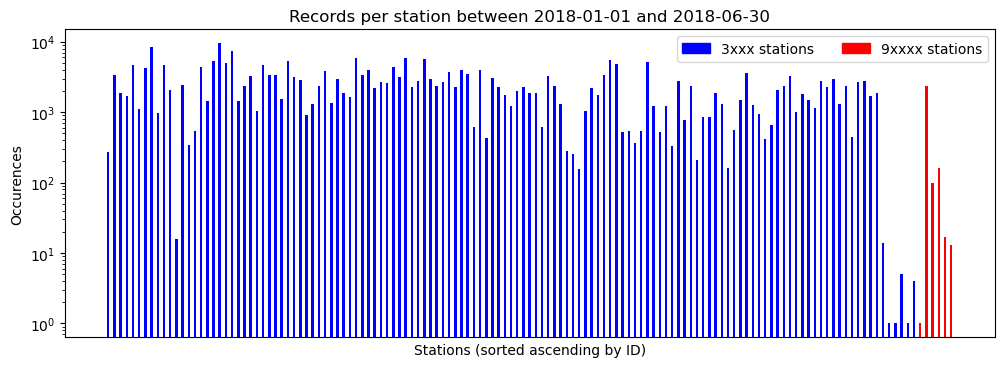

In [35]:
# Setup plot
fig = plt.figure(figsize = (12, 4), dpi = 100)

# Aggregate values and counts (separated for x- and y-axis)
values, counts = np.unique(rentals_df["end_station_id"].loc[rentals_df["start_time"] <= pd.to_datetime("2018-07-01")], return_counts=True)

# Plot bar chart; 9xxxx stations will be marked blue
plt.bar(np.unique(values.astype(str)), counts, width=0.4, color = ["red" if i >= 90000 else "blue" for i in values])

plt.tick_params(labelbottom=False, bottom=False)
plt.xlabel("Stations (sorted ascending by ID)")
plt.ylabel("Occurences")
plt.title("Records per station between 2018-01-01 and 2018-06-30")

# Set log scale
plt.gca().set_yscale("log")

legend_3 = pltptc.Patch(color='blue', label='3xxx stations')
legend_9 = pltptc.Patch(color='red', label='9xxxx stations')
plt.legend(handles=[legend_3, legend_9], ncol = 2)

plt.show()

It can be seen that the 9xxxx stations tend to be represented less than the 3xxx stations.  Due to the low representation of 9xxxx stations in contrast to the 3xxx it is not possible to make a final point on this aspect, but it might be an indicator that those stations were less frequented because those were temporary/concept stations which could also explain the different ID-format.
It can be also seen that the last 6 3xxx stations have a low representation in contrast to all the other 3xxx stations. As it can be seen in the examination of the station data (*which is at this point of time already done and can be found in the accordingly station data examination section in this notebook below*), those stations were introduced by the end/mid of 2018 and may have therefore comparatively less records.

Two other theories seem to be plausible, especially when considering the missing test names (which could be also an indicator for missing data quality, but it is remarkable that the names are only missing for all of the 9xxxx stations):

- Those might be (technical) test records though the rows for "end_station_id" = 9xxxx don't show any abnormalities for the other columns while the records for "start_station_id" = 9xxxx show except for one record all a trip length of 1 minute
- Since there are no records for trips starting at a 9xxxx station and ending in a 3xxx station, these 9xxxx stations might be internal stations where bikes are checked in for maintenance (either when the bikes are taken by staff from a "normal" 3xxx station to the repair station or a mobile service/repair station is called when an accident occured during a trip and the bike was normally checked out)

At this point, it should be remembered that trips where 9xxxx stations are involved are only available until exactly the end of the first half of the year (2018-06-30). Given this fact, the maintenance theory wouldn't make sense anymore since repair cases are obviously likely to appear also in the second half of the year. And even if those are maintenance records, then there is a data quality problem, i.e. the data is not reliable because the second half is missing.

It could be therefore also the case that these stations have been closed in the past, but this is not explaining the missing names and especially not the fact, that the 9xxxx stations were never used as start stations when a "normal" 3xxx station was the end station.

All in all, it is decided to drop these rows to minimize noise on the dataset.
Besides that all theories seem to be vague, this is especially justified due to the fact that there is no further data at all available about the 9xxxx station IDs (which could be for example in combination used for geographical demand patterns) and the predictive analysis would otherwise build upon incomplete time series data for 2018 which is probably also not relevant anymore.  Theoretically, it could be attempted to extrapolate data for the missing second half of the year, but this is adding additional noise to the dataset and the data that would be used for that (the first half year) is already vague.  

Ultimately, a dataset for prediction would be then used which already contains predicted values (second half of the year) based on an incomplete dataset (first half of the year) and is therefore counterproductive in terms of accurate predictive modeling.

As described, all rows with 9xxxx stations are dropped:

In [36]:
rentals_df.drop(rentals_df[(rentals_df["start_station_id"] > 90000) | (rentals_df["end_station_id"] > 90000)].index, inplace = True)

Updated dataset info:

In [37]:
rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 669178 entries, 0 to 671817
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   start_time          669178 non-null  datetime64[ns]
 1   end_time            669178 non-null  datetime64[ns]
 2   start_station_id    669178 non-null  int32         
 3   end_station_id      669178 non-null  int32         
 4   bike_id             669178 non-null  object        
 5   user_type           669178 non-null  object        
 6   start_station_name  669178 non-null  object        
 7   end_station_name    669178 non-null  object        
 8   trip_length         669178 non-null  int32         
 9   is_roundtrip        669178 non-null  bool          
 10  start_time_hourly   669178 non-null  datetime64[ns]
 11  hour                669178 non-null  int64         
 12  weekday             669178 non-null  int64         
 13  weekday_name        669178 no

New row count: 669,178

## Examine variable "bike_id":
    
Remark: This column was imported as object instead of an int (as expected for an ID), since this column contains also alphanumerical values as noticed during the initial import attempt. At the end of this examination section with the corresponding cleansing activities, it was converted to an int.

### Summary 

| **Area** | **Findings** |  |  |  |
|:---|:---|---|---|---|
| **Relevance** | Variable not too meaningful from a domain perspective (consists only of an ID without any further information like bike types) and might remain unused in the further tasks; but kept for now if required in a further task (e.g. analyzing bike usage) |  |  |  |
| **Datatype/Format consistency** | Variable is consistent (numerical values) after manipulation, "delete me" was an alphabetical value that was removed |  |  |  |
| **Faulty records** | Data, i.e. the bike IDs, is considered as correct as there is no validation source if a bike ID is valid. "delete me"-records have been removed |  |  |  |
| **Missing Data** | No Missing Data (669,178 entries from 669,178 total count) |  |  |  |
| **Outliers** | No Outliers (categorical variable; all records are considered) |  |  |  |

### Derived variables

None

### Preparation steps

Get an overall insight into the bike IDs:

In [38]:
# Print all IDs without array truncation (np.inf for infinite amount of values, i.e. print entire array)
with np.printoptions(threshold=np.inf):
    print(np.sort(rentals_df["bike_id"].unique()))

['00003' '02472' '02473' '02474' '02475' '02476' '02477' '02478' '02480'
 '02481' '02492' '02493' '02494' '02496' '02497' '02498' '02499' '02500'
 '02501' '02502' '02503' '02504' '02505' '02506' '02507' '02508' '02509'
 '02510' '02511' '02512' '02513' '02515' '02516' '02517' '02518' '02519'
 '02520' '02521' '02522' '02524' '02526' '02528' '02530' '02531' '02532'
 '02533' '02534' '02536' '02537' '02538' '02539' '02540' '02541' '02542'
 '02543' '02544' '02545' '02546' '02547' '02548' '02550' '02551' '02552'
 '02553' '02554' '02555' '02556' '02557' '02558' '02559' '02560' '02561'
 '02562' '02563' '02564' '02565' '02567' '02569' '02570' '02571' '02572'
 '02573' '02574' '02575' '02576' '02577' '02578' '02579' '02580' '02583'
 '02584' '02585' '02586' '02587' '02588' '02589' '02590' '02591' '02593'
 '02594' '02595' '02596' '02597' '02598' '02599' '02600' '02601' '02602'
 '02603' '02604' '02605' '02606' '02607' '02608' '02609' '02610' '02611'
 '02612' '02613' '02614' '02615' '02619' '02620' '0

Returning the unique bike IDs shows the alphabetical value "delete me". Examining the corresponding records:

In [39]:
rentals_df.loc[rentals_df["bike_id"] == "delete me"]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,trip_length,is_roundtrip,start_time_hourly,hour,weekday,weekday_name,month,month_name,season,is_weekend,is_holiday
637754,2018-11-29 16:05:00,2018-11-29 16:06:00,3122,3122,delete me,Indego365,"24th & Cecil B. Moore, Cecil B. Moore Library","24th & Cecil B. Moore, Cecil B. Moore Library",1,True,2018-11-29 16:00:00,16,3,Thursday,11,November,Autumn,False,False
637757,2018-11-29 16:07:00,2018-11-29 16:09:00,3122,3122,delete me,Indego365,"24th & Cecil B. Moore, Cecil B. Moore Library","24th & Cecil B. Moore, Cecil B. Moore Library",2,True,2018-11-29 16:00:00,16,3,Thursday,11,November,Autumn,False,False
637766,2018-11-29 16:11:00,2018-11-29 16:12:00,3122,3122,delete me,Indego365,"24th & Cecil B. Moore, Cecil B. Moore Library","24th & Cecil B. Moore, Cecil B. Moore Library",1,True,2018-11-29 16:00:00,16,3,Thursday,11,November,Autumn,False,False
637775,2018-11-29 16:14:00,2018-11-30 10:19:00,3122,3000,delete me,Indego365,"24th & Cecil B. Moore, Cecil B. Moore Library",Virtual Station,1085,False,2018-11-29 16:00:00,16,3,Thursday,11,November,Autumn,False,False


Those records are removed since they should be obviously treated like that due to the value "delete me" and "bike_id" can be then converted to an integer (for easier data handling, since "bike_id" itself is not a continuous value).

In [40]:
rentals_df = rentals_df.drop(rentals_df[rentals_df["bike_id"] == "delete me"].index)

# Verify deletion
rentals_df.loc[rentals_df["bike_id"] == "delete me"]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,trip_length,is_roundtrip,start_time_hourly,hour,weekday,weekday_name,month,month_name,season,is_weekend,is_holiday


In [41]:
# Convert "bike_id" to integer
rentals_df["bike_id"] = rentals_df["bike_id"].astype(int)

In [42]:
with np.printoptions(threshold=np.inf):
    print(np.sort(rentals_df["bike_id"].unique()))

[    1     3    14   102   170  2472  2473  2474  2475  2476  2477  2478
  2480  2481  2492  2493  2494  2496  2497  2498  2499  2500  2501  2502
  2503  2504  2505  2506  2507  2508  2509  2510  2511  2512  2513  2515
  2516  2517  2518  2519  2520  2521  2522  2523  2524  2526  2527  2528
  2530  2531  2532  2533  2534  2535  2536  2537  2538  2539  2540  2541
  2542  2543  2544  2545  2546  2547  2548  2549  2550  2551  2552  2553
  2554  2555  2556  2557  2558  2559  2560  2561  2562  2563  2564  2565
  2566  2567  2568  2569  2570  2571  2572  2573  2574  2575  2576  2577
  2578  2579  2580  2583  2584  2585  2586  2587  2588  2589  2590  2591
  2593  2594  2595  2596  2597  2598  2599  2600  2601  2602  2603  2604
  2605  2606  2607  2608  2609  2610  2611  2612  2613  2614  2615  2617
  2619  2620  2621  2622  2623  2624  2625  2626  2627  2629  2630  2631
  2632  2633  2634  2635  2637  2638  2639  2641  2642  2643  2644  2645
  2646  2647  2648  2650  2651  2652  2653  2654  2

Note that all leading zeros of some IDs are omitted with the conversion to int.  
It could be that the leading zeros are stored on purpose to differentiate for example different bike types. This would make sense since IDs are not considered as continuous values (where leading zeros are omitted), but since the given datatype for this column according to the task is explicitly integer and there is also no further data to be connected/joined with the bike IDs, there are no objections in the conversion to integer and losing the leading zeros.

In [43]:
rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 669174 entries, 0 to 671817
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   start_time          669174 non-null  datetime64[ns]
 1   end_time            669174 non-null  datetime64[ns]
 2   start_station_id    669174 non-null  int32         
 3   end_station_id      669174 non-null  int32         
 4   bike_id             669174 non-null  int32         
 5   user_type           669174 non-null  object        
 6   start_station_name  669174 non-null  object        
 7   end_station_name    669174 non-null  object        
 8   trip_length         669174 non-null  int32         
 9   is_roundtrip        669174 non-null  bool          
 10  start_time_hourly   669174 non-null  datetime64[ns]
 11  hour                669174 non-null  int64         
 12  weekday             669174 non-null  int64         
 13  weekday_name        669174 no

New row count: 669,174

There are further suspicious bike IDs that are differing in their format from the vast majority, like bike ID = 1:

In [44]:
rentals_df.loc[rentals_df["bike_id"] == 1]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,trip_length,is_roundtrip,start_time_hourly,hour,weekday,weekday_name,month,month_name,season,is_weekend,is_holiday
170979,2018-05-09 14:40:00,2018-05-09 14:41:00,3166,3166,1,Day Pass,Frankford & Belgrade,Frankford & Belgrade,1,True,2018-05-09 14:00:00,14,2,Wednesday,5,May,Spring,False,False


There is only one record, which is a roundtrip and has a trip length of 1.  
As discussed above, this might be a test trip or a trip where a checkout failed. However, those records won't be omitted at this point, as they will be included for the further analytics process and are a negligible portion of the whole dataset.

Now, the bikes will be examined for "outliers" in terms of that they were used only few times:

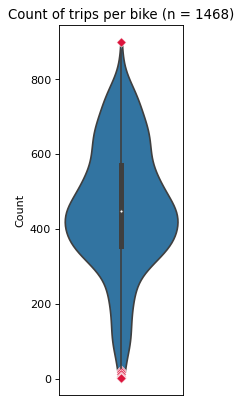

In [45]:
# Setup plot
fig = plt.figure(figsize = (2, 6), dpi = 80)

# Copy rentals dataframe for separation from outliers
ex_df = rentals_df.copy()
counts = ex_df['bike_id'].value_counts().reset_index(name='count')

# Calculate 25 %- and 75 %-quantiles
q1, q3 = np.quantile(counts["count"].values, [0.25, 0.75])

# Calculate outlier thresholds by using standard IQR*1.5-method
wlo = q1-(q3-q1)*1.5
wlo = 0 if wlo < 0 else wlo  # Set 0 (minimum plausible trip length) if mathematically negative
whigh = q3+(q3-q1)*1.5

# Display plot
outliers = counts["count"].values[(counts["count"].values > whigh) | (counts["count"].values < wlo)]
vio = sns.violinplot(data=counts, y='count', cut=0)
vio.tick_params(bottom=False)
vio.set(title="Count of trips per bike (n = " + str(len(counts))+ ")", ylabel="Count")

# Display outliers as scatterplot
sns.scatterplot(y=outliers, x=0, marker='D', color='crimson')

plt.show()

Note that the outliers are calculated using the canonical IQR*1.5-rule.

It can be seen that the bike usage (total trips per bikes) is evenly distributed with some bikes showing higher/less usage than others.  

A high bike usage is nothing unusual from a domain perspective (e.g. because it is a bike that is already for a long time in service or was chosen by coincidence more frequently), even if it is a outlier from a mathematical sense in the upper outlier range. This applies also to the outlier at around 900 trip counts, which is determined as outlier because of the mathematics.

The same applies vice versa to the bikes that are less used and are also marked as outliers in the lower outlier range.
Nevertheless, it should be remembered that there are few bikes that have a different ID format (one or three digits) than the huge majority (four or five digits) of all bikes.

In [46]:
# Review bike IDs with unusual format (one or three digits)
rentals_df["bike_id"].loc[rentals_df["bike_id"] <= 1000].unique()

array([102, 170,  14,   1,   3])

In [47]:
# Review mathematical outliers
counts.values[(counts["count"].values > whigh) | (counts["count"].values < wlo)]

array([[11171,   899],
       [ 3720,    22],
       [ 5269,    21],
       [ 2721,    18],
       [14514,    12],
       [ 5267,    12],
       [ 5178,     8],
       [14620,     4],
       [14613,     4],
       [   14,     2],
       [    3,     1],
       [14635,     1],
       [    1,     1]], dtype=int64)

It can be seen that indeed three of the five bikes with an unusual ID are included in the outliers with the lowest occurences: bike 1 and 3 with one record and bike 14 with two records.

In [48]:
rentals_df.loc[rentals_df["bike_id"].isin([1,3,14])]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,trip_length,is_roundtrip,start_time_hourly,hour,weekday,weekday_name,month,month_name,season,is_weekend,is_holiday
68518,2018-03-06 09:23:00,2018-03-06 10:57:00,3022,3159,14,Indego30,Amtrak 30th Street Station,38th & Spruce,94,False,2018-03-06 09:00:00,9,1,Tuesday,3,March,Spring,False,False
68620,2018-03-06 11:00:00,2018-03-11 16:51:00,3159,3047,14,Indego30,38th & Spruce,"Independence Mall, NPS",7551,False,2018-03-06 11:00:00,11,1,Tuesday,3,March,Spring,False,False
170979,2018-05-09 14:40:00,2018-05-09 14:41:00,3166,3166,1,Day Pass,Frankford & Belgrade,Frankford & Belgrade,1,True,2018-05-09 14:00:00,14,2,Wednesday,5,May,Spring,False,False
630642,2018-11-22 13:53:00,2018-11-26 14:02:00,3122,3122,3,Indego365,"24th & Cecil B. Moore, Cecil B. Moore Library","24th & Cecil B. Moore, Cecil B. Moore Library",5769,True,2018-11-22 13:00:00,13,3,Thursday,11,November,Autumn,False,True


The records themselves are not unusual from their values, although the theory regarding bikes that have lower usage being new bikes seems at least not plausible for bike 1 and 14, which are already in service since at least May 2018 respectively March 2018.

In [49]:
rentals_df.loc[rentals_df["bike_id"].isin([14514,5178,14613])]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,trip_length,is_roundtrip,start_time_hourly,hour,weekday,weekday_name,month,month_name,season,is_weekend,is_holiday
388980,2018-08-03 15:48:00,2018-08-03 16:27:00,3188,3188,14613,Indego30,"Broad & Pattison, BSL","Broad & Pattison, BSL",39,True,2018-08-03 15:00:00,15,4,Friday,8,August,Summer,False,False
389084,2018-08-03 16:28:00,2018-08-03 16:41:00,3188,3188,14613,Indego30,"Broad & Pattison, BSL","Broad & Pattison, BSL",13,True,2018-08-03 16:00:00,16,4,Friday,8,August,Summer,False,False
394142,2018-08-05 20:46:00,2018-08-05 21:02:00,3188,3158,14613,Indego30,"Broad & Pattison, BSL",Broad & Passyunk,16,False,2018-08-05 20:00:00,20,6,Sunday,8,August,Summer,True,False
394396,2018-08-06 00:46:00,2018-08-10 17:08:00,3158,3000,14613,Indego30,Broad & Passyunk,Virtual Station,6742,False,2018-08-06 00:00:00,0,0,Monday,8,August,Summer,False,False
456383,2018-08-29 18:43:00,2018-08-29 19:05:00,3056,3123,14514,Indego365,Broad & Oxford,22nd & Cecil B. Moore,22,False,2018-08-29 18:00:00,18,2,Wednesday,8,August,Summer,False,False
459672,2018-08-30 22:17:00,2018-08-30 22:25:00,3088,3013,14514,Indego30,3rd & Girard,6th & Fairmount,8,False,2018-08-30 22:00:00,22,3,Thursday,8,August,Summer,False,False
460961,2018-08-31 16:41:00,2018-08-31 16:50:00,3033,3013,14514,Indego30,10th & Chestnut,6th & Fairmount,9,False,2018-08-31 16:00:00,16,4,Friday,8,August,Summer,False,False
461724,2018-09-01 11:14:00,2018-09-01 11:21:00,3013,3065,14514,Indego30,6th & Fairmount,Girard & Hutchinson,7,False,2018-09-01 11:00:00,11,5,Saturday,9,September,Autumn,True,False
466097,2018-09-03 09:05:00,2018-09-03 09:10:00,3065,3088,14514,Indego30,Girard & Hutchinson,3rd & Girard,5,False,2018-09-03 09:00:00,9,0,Monday,9,September,Autumn,False,True
471286,2018-09-05 13:51:00,2018-09-05 14:12:00,3077,3031,14514,Indego30,17th & Girard,13th & Montgomery,21,False,2018-09-05 13:00:00,13,2,Wednesday,9,September,Autumn,False,False


A sample of other bikes that are considered as "usual" in regards of their bike ID are showing a similar behavior: Only few trips are done within a small period of time.

Overall, it is decided to not drop those records in the lower outlier boundary as it seems not likely that those are - at least exclusively - e.g. test trips done by staff and it's not possible to point out such a concrete theory and finally verify it.  
The same applies to the outlier in the upper outlier boundary which is also a mathematical outlier, but not such one from a domain perspective.

In case that those records are partially indeed test trips, it will remain as noise in the dataset.

In [50]:
rentals_df.describe()

,start_station_id,end_station_id,bike_id,trip_length,hour,weekday,month
count,669174.000000,669174.000000,669174.000000,669174.000000,669174.000000,669174.000000,669174.000000
mean,3068.778712,3068.021533,7270.166348,21.264581,13.830551,2.787357,6.838292
std,50.234882,50.422301,4334.408036,80.071573,4.973236,1.908830,2.918150
min,3000.000000,3000.000000,1.000000,1.000000,0.000000,0.000000,1.000000
25%,3028.000000,3027.000000,3462.000000,7.000000,10.000000,1.000000,5.000000
50%,3056.000000,3055.000000,5277.000000,11.000000,15.000000,3.000000,7.000000
75%,3102.000000,3102.000000,11807.000000,18.000000,18.000000,4.000000,9.000000
max,3192.000000,3192.000000,15073.000000,7551.000000,23.000000,6.000000,12.000000


New row count: 669,174

## Examine variable "user_type":

### Summary

| **Area** | **Findings** |  |  |  |
|:---|:---|---|---|---|
| **Relevance** | Variable is meaningful from a domain perspective (gives information about which products are used by the customer) |  |  |  |
| **Datatype/Format consistency** | Variable is consistent (any string allowed) |  |  |  |
| **Faulty records** | "Day Pass" and "One Day Pass" were merged into "Day Pass" since they seem to describe the same term |  |  |  |
| **Missing Data** | No missing data (669,174 entries for both columns from 669,174 total count) |  |  |  |
| **Outliers** | No outliers (categorical variable; all records are considered) |  |  |  |

### Derived variables

| **Name** | **Type (dtype)** | **Purpose** |
|:---|:---|:---|
| is_subscription| Boolean (bool) | Describes if the user_type is a subscription (Indego30, Indego365, IndegoFlex) |

### Preparation steps

In [51]:
rentals_df[["user_type"]].describe()

,user_type
count,669174
unique,6
top,Indego30
freq,478723


In [52]:
rentals_df["user_type"].value_counts()

Indego30        478723
Indego365        94400
Day Pass         80151
Walk-up          11616
IndegoFlex        3853
One Day Pass       431
Name: user_type, dtype: int64

Product names and count values are plausible in general, although "One Day Pass" and "Day Pass" will be merged since they seem to represent the same product just with a slightly different name.  
It appears likely that the "Day Pass" is replacing the "One Day Pass", since the former one has 80,151 records whereas the latter one has only 431 records.  
Since it could be also the case that the "One Day Pass" was introduced by the end of the year and the exact opposite is the case, the timestamps for the accordingly records will be reviewed:

In [53]:
print("Records for \"One Day Pass\":")
print(rentals_df["start_time"].loc[rentals_df["user_type"] == "One Day Pass"].describe(datetime_is_numeric=True))
print("\nRecords for \"Day Pass\":")
print(rentals_df["start_time"].loc[rentals_df["user_type"] == "Day Pass"].describe(datetime_is_numeric=True))

Records for "One Day Pass":
count                              431
mean     2018-02-09 16:50:03.758700544
min                2018-01-05 08:29:00
25%                2018-01-22 12:42:00
50%                2018-02-08 17:41:00
75%                2018-02-20 02:41:30
max                2018-03-11 18:31:00
Name: start_time, dtype: object

Records for "Day Pass":
count                            80151
mean     2018-07-27 16:00:17.832091648
min                2018-04-01 09:51:00
25%                2018-06-09 13:31:00
50%                2018-07-22 14:22:00
75%                2018-09-08 13:06:30
max                2018-12-31 23:33:00
Name: start_time, dtype: object


The "One Day Pass" was indeed replaced by the Day Pass since the last day a "One Day Pass" was used is 2018-03-11 and the first day the "Day Pass" was used is 2018-04-01.  
As described, the "One Day Pass" will therefore be converted into the "Day Pass" as it is highly anticipated that they describe the same product: A ticket for using the bike sharing for a day.

In [54]:
# Replace value "One Day Pass" with value "Day pass"
rentals_df["user_type"].replace({"One Day Pass": "Day Pass"}, inplace = True)

# Verify conversion
rentals_df["user_type"].value_counts() 

Indego30      478723
Indego365      94400
Day Pass       80582
Walk-up        11616
IndegoFlex      3853
Name: user_type, dtype: int64

Finally, the variable "is_subscription" is derived, which describes, if the user_type belongs to a subscription (Indego30, Indego365 and IndegoFlex) oder is a daily/normal ticket (Day Pass/Walk-up).

In [55]:
rentals_df["is_subscription"] = rentals_df["user_type"].isin(["Indego30", "Indego365", "IndegoFlex"])

## Examine variables "start_station_name" and "end_station_name":

Both variables are deleted during the examination for redundancy reduction since they are also included in the station dataset (and can then be joined through the station ID) which is also being examined in the following.

### Summary

| **Area** | **Findings** |  |  |  |
|:---|:---|---|---|---|
| **Relevance** | Variable is meaningful from a domain perspective in order to match the station IDs to actual geographical locations and perform geographical demand analyses |  |  |  |
| **Datatype/Format consistency** | Variable is consistent (alphanumerical values as expected for addresses) |  |  |  |
| **Faulty records** | No faulty values (i.e. cut off values). Stations with a station ID = 9xxxx format had the station ID as name, but this is not relevant anymore as the affected records have been deleted during the examination of "start_station_id" and "end_station_id" |  |  |  |
| **Missing Data** | No Missing Data (669,174 entries from 669,174 total count) |  |  |  |
| **Outliers** | No Outliers (categorical variable) |  |  |  |

### Derived variables

None

### Preparation steps

In [56]:
rentals_df[["start_station_name", "end_station_name"]].describe()

,start_station_name,end_station_name
count,669174,669174
unique,135,135
top,15th & Spruce,18th & JFK
freq,17512,20520


The examination for "start_station_name" and "end_station_name" is about to verify if the names are consistent and valid.  

For that, it is checked if:
- The start station names and end station names are consistent (so every station ID has only one unique name for every occurence)
- The station names are plausible (no cut off values/faulty data like single-character values)
- Finally to verify the names against the station information data "indego-stations-2022-10-01.csv" (see introduction for more information)

To start, the start station names and end station names are checked for consistency.  
This is achieved by creating a dataset that contains all ID-name-pairs of the start station and all ID-name pairs of the end station.  
The dataset will then be reduced by dropping all duplicate values which should then result into a dataset that contains every station ID only once which indicates that there are no stations with different names.

(Note that in contrast it could occur that a station name appears twice which could be theoretically plausible, e.g. when two stations are located next to each other very near in a long street - as opposed to an ID which is naturally an unique identifier.)

In [57]:
"""
Extract the ID-name pairs for the start stations and end stations and rename the columns equally 
(duplicates within the accordingly dataset are already prefiltered here)
""" 
rentals_df_start_station = rentals_df[["start_station_id", "start_station_name"]].drop_duplicates().rename(columns={"start_station_id":"station_id","start_station_name":"station_name"})
rentals_df_end_station = rentals_df[["end_station_id", "end_station_name"]].drop_duplicates().rename(columns={"end_station_id":"station_id","end_station_name":"station_name"})

# Union datasets, remove duplicate pairs and sort the dataset by station ID for review
rentals_df_station_set = pd.concat([rentals_df_start_station, rentals_df_end_station]).drop_duplicates().sort_values(by="station_id",ascending = True)

# Check if station IDs appear only once within the dataset which means that the ID-name pairs are consistent
print("Unique station IDs:", rentals_df_station_set["station_id"].nunique(), "\nTotal row count:", rentals_df_station_set.shape[0])

Unique station IDs: 135 
Total row count: 135


Station names and end station names are consistent since every station occurs only once per ID (135 unique station IDs of 135 total records).  

Manual verification of station names in regards of cut off values/faulty data like single-character values:

In [58]:
pd.options.display.max_rows = rentals_df_station_set.shape[0] # Adjust row display to row count of dataframe
rentals_df_station_set

,station_id,station_name
189489,3000,Virtual Station
118,3004,Municipal Services Building Plaza
344,3005,"Welcome Park, NPS"
174,3006,40th & Spruce
15,3007,"11th & Pine, Kahn Park"
130,3008,Temple University Station
503,3009,33rd & Market
75,3010,15th & Spruce
59,3011,38th & Powelton
40,3012,21st & Catharine


In [59]:
pd.reset_option('^display.', silent=True) # Reset maximum row display

It is assumed that the station names are plausible and are therefore correct values since there are no obvious abnormalities.  

Indego provides the mentioned additional station information dataset which will be now matched with the main dataset to further proof consistency regarding correct station IDs and station names:

## Examination: indego-stations-2022-10-01.csv

Note: No detailed separate examination for all variables is done here as opposed to the rental dataset as all relevant variables need to be examined/manipulated in parallel as visible in the following.

### Preparation steps

In [60]:
# Read column names
pd.read_csv("data/indego-stations-2022-10-01.csv", nrows=0)

,Station_ID,Station_Name,Day of Go_live_date,Status,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18


In [61]:
stations_df = pd.read_csv("data/indego-stations-2022-10-01.csv",
                         dtype={"Station_ID":"int",
                                "Station_Name":"str",
                                "Status":"str"},
                          parse_dates=["Day of Go_live_date"])
stations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Station_ID           200 non-null    int32         
 1   Station_Name         200 non-null    object        
 2   Day of Go_live_date  200 non-null    datetime64[ns]
 3   Status               200 non-null    object        
 4   Unnamed: 4           0 non-null      float64       
 5   Unnamed: 5           0 non-null      float64       
 6   Unnamed: 6           0 non-null      float64       
 7   Unnamed: 7           0 non-null      float64       
 8   Unnamed: 8           0 non-null      float64       
 9   Unnamed: 9           0 non-null      float64       
 10  Unnamed: 10          0 non-null      float64       
 11  Unnamed: 11          0 non-null      float64       
 12  Unnamed: 12          0 non-null      float64       
 13  Unnamed: 13          0 non-null    

Many unnamed columnns with no rows except for column "Unnamed: 18" appear.  
Check what the single non-null entry is about:

In [62]:
stations_df["Unnamed: 18"][stations_df['Unnamed: 18'].notnull()] 

20    indego-stations-2022-07-01
Name: Unnamed: 18, dtype: object

Update dataframe by omitting indexes 4-18 since those columns exist due to faulty file format:

In [63]:
stations_df = stations_df.drop(stations_df.iloc[:, 4:19],axis=1)

Rename columns for consistency across datasets (especially the ones that have just been created for reviewing the station names) and uniform naming conventions:

In [64]:
stations_df.rename(columns={"Station_ID":"station_id"}, inplace=True)
stations_df.rename(columns={"Station_Name":"station_name"}, inplace=True)
stations_df.rename(columns={"Day of Go_live_date":"go_live_date"}, inplace=True)
stations_df.rename(columns={"Status":"status"}, inplace=True)
stations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   station_id    200 non-null    int32         
 1   station_name  200 non-null    object        
 2   go_live_date  200 non-null    datetime64[ns]
 3   status        200 non-null    object        
dtypes: datetime64[ns](1), int32(1), object(2)
memory usage: 5.6+ KB


In [65]:
stations_df["go_live_date"].describe(datetime_is_numeric=True)

count                    200
mean     2017-09-28 00:07:12
min      2015-04-23 00:00:00
25%      2015-04-23 00:00:00
50%      2016-05-04 12:00:00
75%      2019-11-16 06:00:00
max      2022-09-07 00:00:00
Name: go_live_date, dtype: object

Values for variable "go_live_data" are plausible without missing data.

In [66]:
stations_df["status"].value_counts()

Active      180
Inactive     20
Name: status, dtype: int64

Values for variable "status" are plausible without missing data.

The dataset is reduced by omitting all rows where "go_live_date" > 2019-01-02 since this is the most recent date with a record in the rental dataset and any further updates/new stations are therefore not relevant.

In [67]:
stations_df = stations_df.drop(stations_df[stations_df["go_live_date"] > pd.to_datetime("2019-01-02")].index)

Now, the station information dataset "stations_df" and the derived dataset out of the rental dataset for checking name consistency "rentals_df_station_set" is being joined on "station_id".  
With that, each station name of the corresponding dataset can be compared and checked if it is equal.

In [68]:
# Create copy of station information dataset with a different column name for distinctness
stations_df_renamed = stations_df.rename(columns={"station_name":"station_name_master_data"})

In [69]:
stations_merged_df = pd.merge(rentals_df_station_set,stations_df_renamed, on="station_id", how="outer").sort_values(by="station_id", ascending=True)
pd.options.display.max_rows = stations_merged_df.shape[0] # Adjust row display to row count of dataframe
stations_merged_df

,station_id,station_name,station_name_master_data,go_live_date,status
0,3000,Virtual Station,Virtual Station,2015-04-23,Active
1,3004,Municipal Services Building Plaza,Municipal Services Building Plaza,2015-04-23,Active
2,3005,"Welcome Park, NPS","Welcome Park, NPS",2015-04-23,Active
3,3006,40th & Spruce,40th & Spruce,2015-04-23,Active
4,3007,"11th & Pine, Kahn Park","11th & Pine, Kahn Park",2015-04-23,Active
5,3008,Temple University Station,Temple University Station,2015-04-23,Active
6,3009,33rd & Market,33rd & Market,2015-04-23,Active
7,3010,15th & Spruce,15th & Spruce,2015-04-23,Active
8,3011,38th & Powelton,38th & Powelton,2015-04-23,Inactive
9,3012,21st & Catharine,21st & Catharine,2015-04-23,Active


In [70]:
pd.reset_option('^display.', silent=True) # Reset maximum row display

Now we can first of all drop rows where "station_name" equals "station_name_master_data	 because we can be then sure, that those stations are named consistent.

In [71]:
stations_merged_df.loc[stations_merged_df["station_name"] != stations_merged_df["station_name_master_data"]]

,station_id,station_name,station_name_master_data,go_live_date,status
23,3026,2nd & South,2nd & Lombard,2015-04-23,Active
135,3048,NaN,Broad & Fitzwater,2015-04-23,Inactive
136,3105,NaN,Penn Treaty Park,2016-05-03,Inactive
137,3109,NaN,Parkside & Girard,2016-05-06,Inactive


Two things can now be observed:
- Station 3026 has a different name for the station information ("2nd & Lombard") and rental dataset ("2nd & South"). A quick look into Google Maps reveals that both streets are crossing each and it is therefore decided to leave the station name in the rental dataset as it is, since this depicts the state as of 2018 (and the station has been probably renamed in the meantime).    
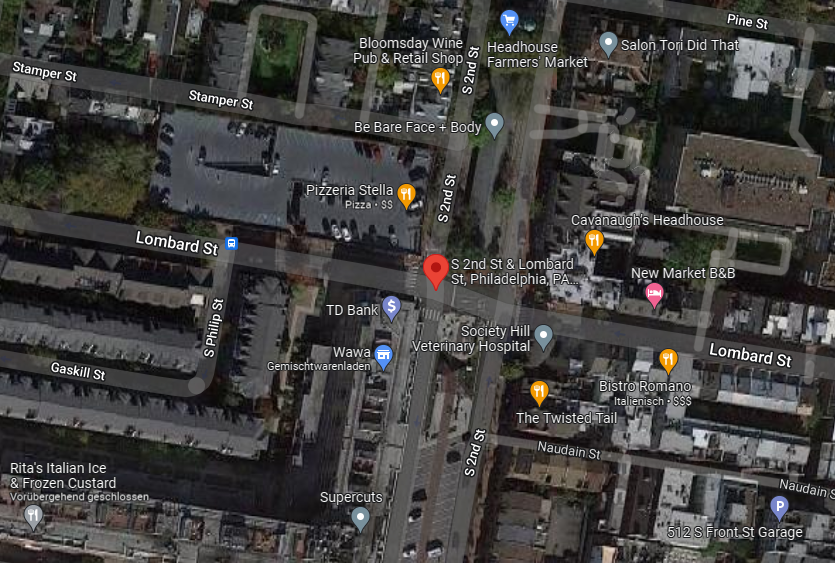  
- Stations 3048, 3105 and 3109 have no records in the rental dataset since they were probably already inactive before 2018 (remember that the "status"-column is as of 2022-10-01, so this is only an assumption which is however very likely from a logical perspective).

All other stations have consistent station names.  

In order to keep the datasets slim, the columns "start_station_name" and "end_station_name" of the rental dataset will be deleted since they are redundant with the names from the station information dataset.  For that, the name of station 3026 will be renamed from "2nd & Lombard" to "2nd & South" in the station information dataset since the naming from 2018 shall be used (as it is the case in the given rental dataset) as explained above.  

In terms of the station information dataset, "go_live_date" will be kept as it might be useful for further analyses.  
However, the column "status" is irreleveant as the working basis is the rental dataset and all stations are considered relevant (and stations that are marked as inactive as of 2022-10-01 might have been still active in 2018/this is the assumption to work with).  

When the station information dataset is required in further analyses, it can be joined on the rental dataset on the station ID.

In [72]:
# Drop columns "start_station_name" and "end_station_name" from rental dataset
rentals_df.drop(["start_station_name", "end_station_name"], axis = 1, inplace = True)

# Rename station 3026 in station dataset to explicitly "2nd & South"
stations_df.loc[stations_df["station_id"] == 3026, "station_name"] = "2nd & South"

# Drop column "status" from 
stations_df.drop("status", axis = 1, inplace = True)

In [73]:
# Review of prepared station information dataset
stations_df

,station_id,station_name,go_live_date
0,3000,Virtual Station,2015-04-23
1,3004,Municipal Services Building Plaza,2015-04-23
2,3005,"Welcome Park, NPS",2015-04-23
3,3006,40th & Spruce,2015-04-23
4,3007,"11th & Pine, Kahn Park",2015-04-23
...,...,...,...
133,3186,12th & Normandy,2018-06-19
134,3187,20th & Race,2018-09-25
135,3188,"Broad & Pattison, BSL",2018-06-19
136,3190,17th & Locust,2018-09-14


Finally, the handling of the "Virtual Station" with station ID 3000 needs to be done.

https://www.rideindego.com/about/data/ (retrieved on December 18, 2022) states the following about "Virtual Station":

> A “Virtual Station” listed in the checkout and return kiosks, is used by staff to check in or check out a bike remotely for a special event or in a situation in which a bike could not otherwise be checked in or out to a station.

This means that the record itself and therefore the trip is valid, but the check-out/check-in was done remotely and not by the user itself. The station information is therefore lost as the records indicate, but demand for a bike/a trip in general was there.  
Therefore, the records will be kept and the "Virtual Stations" can be used as an indicator for problems when it comes to the descriptive analysis.

In [74]:
rentals_df.loc[rentals_df["start_station_id"] == 3000]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,trip_length,is_roundtrip,start_time_hourly,hour,weekday,weekday_name,month,month_name,season,is_weekend,is_holiday,is_subscription
189489,2018-05-18 06:04:00,2018-05-18 06:15:00,3000,3033,11754,Indego30,11,False,2018-05-18 06:00:00,6,4,Friday,5,May,Spring,False,False,True
189567,2018-05-18 07:35:00,2018-05-18 07:48:00,3000,3027,5341,Indego30,13,False,2018-05-18 07:00:00,7,4,Friday,5,May,Spring,False,False,True
189615,2018-05-18 08:03:00,2018-05-18 08:20:00,3000,3029,3288,IndegoFlex,17,False,2018-05-18 08:00:00,8,4,Friday,5,May,Spring,False,False,True
189653,2018-05-18 08:15:00,2018-05-18 08:26:00,3000,3022,3575,Indego30,11,False,2018-05-18 08:00:00,8,4,Friday,5,May,Spring,False,False,True
189666,2018-05-18 08:21:00,2018-05-18 08:34:00,3000,3160,11908,Indego30,13,False,2018-05-18 08:00:00,8,4,Friday,5,May,Spring,False,False,True
189681,2018-05-18 08:27:00,2018-05-18 08:48:00,3000,3033,11734,Indego30,21,False,2018-05-18 08:00:00,8,4,Friday,5,May,Spring,False,False,True
189682,2018-05-18 08:27:00,2018-05-18 08:35:00,3000,3021,11783,Indego365,8,False,2018-05-18 08:00:00,8,4,Friday,5,May,Spring,False,False,True
189766,2018-05-18 09:02:00,2018-05-18 09:15:00,3000,3023,2588,Indego30,13,False,2018-05-18 09:00:00,9,4,Friday,5,May,Spring,False,False,True
189782,2018-05-18 09:11:00,2018-05-18 09:16:00,3000,3060,3323,Indego30,5,False,2018-05-18 09:00:00,9,4,Friday,5,May,Spring,False,False,True
189811,2018-05-18 09:35:00,2018-05-18 10:12:00,3000,3015,11752,Indego365,37,False,2018-05-18 09:00:00,9,4,Friday,5,May,Spring,False,False,True


## Examination: station_status_20221210_171330.json

This dataset provides various information about all stations that are static (such as location coordinates, address with street and zip code) as well as live data such as available bikes with battery status or available docks (in this case a snapshot from 2022-12-10 17:13:30).  

The following static information is used to enrich the existing station information dataset:
- latitude (Integer; part of coordinates that can be used for visualization purposes)
- longitude (Integer; part of coordinates that can be used for visualization purposes)
- addressZipCode (Integer; can be used for visualization purposes)

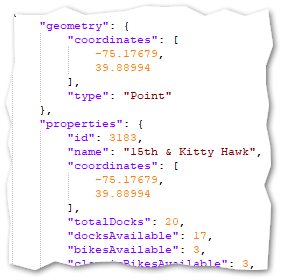

In [75]:
# Load JSON file
station_geo_info_df = json.load(open("data/station_status_20221210_171330.json"))

In [76]:
station_geo_info_df = pd.json_normalize(station_geo_info_df["features"])
station_geo_info_df

,type,geometry.coordinates,geometry.type,properties.id,properties.name,properties.coordinates,properties.totalDocks,properties.docksAvailable,properties.bikesAvailable,properties.classicBikesAvailable,...,properties.isEventBased,properties.isVirtual,properties.kioskId,properties.notes,properties.openTime,properties.publicText,properties.timeZone,properties.trikesAvailable,properties.latitude,properties.longitude
0,Feature,"[-75.16374, 39.95378]",Point,3004,Municipal Services Building Plaza,"[-75.16374, 39.95378]",30,5,24,22,...,False,False,3004,None,None,,None,0,39.95378,-75.16374
1,Feature,"[-75.14403, 39.94733]",Point,3005,"Welcome Park, NPS","[-75.14403, 39.94733]",13,8,5,3,...,False,False,3005,None,None,,None,0,39.94733,-75.14403
2,Feature,"[-75.20311, 39.9522]",Point,3006,40th & Spruce,"[-75.20311, 39.9522]",17,16,1,0,...,False,False,3006,None,None,,None,0,39.95220,-75.20311
3,Feature,"[-75.15993, 39.94517]",Point,3007,"11th & Pine, Kahn Park","[-75.15993, 39.94517]",20,14,6,5,...,False,False,3007,None,None,,None,0,39.94517,-75.15993
4,Feature,"[-75.15067, 39.98081]",Point,3008,Temple University Station,"[-75.15067, 39.98081]",17,11,6,3,...,False,False,3008,None,None,,None,0,39.98081,-75.15067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,Feature,"[-75.16027, 39.95028]",Point,3295,12th & Chestnut,"[-75.16027, 39.95028]",21,14,7,3,...,False,False,3295,None,None,,None,0,39.95028,-75.16027
183,Feature,"[-75.16758, 39.95134]",Point,3296,16th & Chestnut,"[-75.16758, 39.95134]",21,9,11,8,...,False,False,3296,None,None,,None,0,39.95134,-75.16758
184,Feature,"[-75.20691, 39.94717]",Point,3298,42nd & Woodland,"[-75.20691, 39.94717]",21,17,4,0,...,False,False,3298,None,None,,None,0,39.94717,-75.20691
185,Feature,"[-75.15698, 39.94332]",Point,3299,9th & Lombard,"[-75.15698, 39.94332]",22,9,13,4,...,False,False,3299,None,None,,None,0,39.94332,-75.15698


In [77]:
station_geo_info_df = station_geo_info_df[["properties.id", "properties.latitude", "properties.longitude", "properties.addressZipCode"]]
station_geo_info_df.rename({'properties.id': 'station_id', 'properties.latitude': 'latitude', 'properties.longitude': 'longitude', 'properties.addressZipCode': 'zipcode'}, axis=1, inplace=True)

C:\Users\wayne\AppData\Local\Temp\ipykernel_20580\467299225.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_geo_info_df.rename({'properties.id': 'station_id', 'properties.latitude': 'latitude', 'properties.longitude': 'longitude', 'properties.addressZipCode': 'zipcode'}, axis=1, inplace=True)


In [78]:
# Left join on station information dataset via "station_id"
stations_df = pd.merge(stations_df, station_geo_info_df, how = "left")

In [79]:
stations_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138 entries, 0 to 137
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   station_id    138 non-null    int32         
 1   station_name  138 non-null    object        
 2   go_live_date  138 non-null    datetime64[ns]
 3   latitude      120 non-null    float64       
 4   longitude     120 non-null    float64       
 5   zipcode       120 non-null    object        
dtypes: datetime64[ns](1), float64(2), int32(1), object(2)
memory usage: 7.0+ KB


It can be seen from the dataset info that the geoinformation "latitude", "longitude" and "zipcode" are missing for some records.

In [80]:
stations_df.loc[stations_df["latitude"].isnull()]

,station_id,station_name,go_live_date,latitude,longitude,zipcode
0,3000,Virtual Station,2015-04-23,NaN,NaN,NaN
8,3011,38th & Powelton,2015-04-23,NaN,NaN,NaN
10,3013,6th & Fairmount,2015-04-23,NaN,NaN,NaN
20,3023,Rittenhouse Square,2015-04-23,NaN,NaN,NaN
24,3027,"40th Street Station, MFL",2015-04-23,NaN,NaN,NaN
33,3036,2nd & Germantown,2015-04-23,NaN,NaN,NaN
43,3048,Broad & Fitzwater,2015-04-23,NaN,NaN,NaN
76,3095,29th & Diamond,2016-04-28,NaN,NaN,NaN
84,3103,"27th & Master, Athletic Recreation Center",2016-05-03,NaN,NaN,NaN
86,3105,Penn Treaty Park,2016-05-03,NaN,NaN,NaN


In order to fill this information, the address in "station_name" is used to lookup the latitude and longitude by using ArcGIS and zipcode by using Nominatim.  
Since this information can be only retrieved approximately because the coordinates of the station itself can't be retrieved by the address, a column "approximate_location" indicates the completion by using the geocoding services.

The "Virtual Station" is excluded from this procedure since it is not a real station as already elaborated.

In [81]:
# Initialize user agent for ArcGIS, only naming our application
geopy_coordinates = ArcGIS(user_agent = "team_assignment_philadelphia_2018")

# Indicate the rows with missing geoinformation except "Virtual Station"
for index, row in stations_df.loc[(stations_df["latitude"].isnull()) & (stations_df["station_name"] != "Virtual Station")].iterrows():
    response =  geopy_coordinates.geocode(query=row["station_name"] + ", Philadelphia, USA")
    stations_df.loc[index, "latitude"] = response.latitude
    stations_df.loc[index, "longitude"] = response.longitude
    stations_df.loc[index, "approximate_location"] = True

In [82]:
# Initialize user agent for Nominatim, only naming our application
geopy_zipcode = Nominatim(user_agent = "team_assignment_philadelphia_2018")

# Indicate the rows with missing geoinformation by "approximate_location", which was already set by retrieving the coordinates with ArcGIS
for index, row in stations_df.loc[stations_df["approximate_location"] == True].iterrows():
    response = geopy_zipcode.reverse((row["latitude"], row["longitude"]))
    stations_df.loc[index, "zipcode"] = response.raw["address"]["postcode"]

In [83]:
# Review completed records
stations_df.loc[stations_df["approximate_location"] == True]

,station_id,station_name,go_live_date,latitude,longitude,zipcode,approximate_location
8,3011,38th & Powelton,2015-04-23,39.95957,-75.19710,19104,True
10,3013,6th & Fairmount,2015-04-23,39.96350,-75.14784,19123,True
20,3023,Rittenhouse Square,2015-04-23,39.94711,-75.16943,19103,True
24,3027,"40th Street Station, MFL",2015-04-23,39.95700,-75.20220,19104,True
33,3036,2nd & Germantown,2015-04-23,39.96797,-75.13987,19123,True
43,3048,Broad & Fitzwater,2015-04-23,39.94181,-75.16590,19146,True
76,3095,29th & Diamond,2016-04-28,39.98785,-75.18062,19121,True
84,3103,"27th & Master, Athletic Recreation Center",2016-05-03,39.97719,-75.17978,19121,True
86,3105,Penn Treaty Park,2016-05-03,39.96655,-75.13013,19125,True
89,3108,15th & Market,2016-05-04,39.95259,-75.16521,19107,True


In [84]:
# Assign "approximate_location" = False for all other rows except "Virtual Station"
for index, row in stations_df.loc[stations_df["approximate_location"].isnull() & (stations_df["station_name"] != "Virtual Station") ].iterrows():
    stations_df.loc[index, "approximate_location"] = False

In [85]:
stations_df.describe()

,station_id,latitude,longitude
count,138.000000,137.000000,137.000000
mean,3085.405797,39.954309,-75.170090
std,55.635891,0.017742,0.020106
min,3000.000000,39.889940,-75.223990
25%,3037.250000,39.945730,-75.180910
50%,3073.500000,39.953800,-75.169800
75%,3121.750000,39.966640,-75.156720
max,3192.000000,39.991790,-75.129940


In [86]:
stations_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138 entries, 0 to 137
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   station_id            138 non-null    int32         
 1   station_name          138 non-null    object        
 2   go_live_date          138 non-null    datetime64[ns]
 3   latitude              137 non-null    float64       
 4   longitude             137 non-null    float64       
 5   zipcode               137 non-null    object        
 6   approximate_location  137 non-null    object        
dtypes: datetime64[ns](1), float64(2), int32(1), object(3)
memory usage: 12.2+ KB


In [87]:
# Save result as backup; not activated by default and only for fallback purposes in the future

#stations_df.to_csv("data_prepared/stations_df_applied_geoservices.csv", sep=",", encoding="utf-8", index=False)

## Extension of rentals dataset: Distance and km/h

With the now fully available station information including the coordinates, the distance between the start and end station of a trip can be calculated.  
For that, first of all the coordinates for the each the start and end station is merged into the rentals dataset:

In [88]:
# Merge rentals with start station information
rentals_df = pd.merge(rentals_df, stations_df[["station_id","latitude", "longitude"]],
                     left_on="start_station_id",
                     right_on="station_id", 
                     how = 'left')

rentals_df.drop('station_id', axis=1, inplace=True)

rentals_df.rename({"latitude":"start_lat","longitude":"start_long"}, axis = 1, inplace = True)

# Merge rentals with end station information
rentals_df = pd.merge(rentals_df, stations_df[["station_id","latitude", "longitude"]],
                     left_on="end_station_id",
                     right_on="station_id", 
                     how = 'left')
rentals_df.drop('station_id', axis=1, inplace=True)

rentals_df.rename({"latitude":"end_lat","longitude":"end_long"}, axis = 1, inplace = True)

Keep in mind that the distance can only be an approximation since it is the shortest distance due to lack of the exact route and so is also the kmh-value only an approximation.  
The calculation is done for all stations except the "Virtual Station", as there is no location available for it.

In [89]:
# Iterate through all records and calculate the distance using geopy
for index, row in rentals_df.loc[(rentals_df["start_station_id"] != 3000) & (rentals_df["end_station_id"] != 3000)].iterrows():
    coords_1 = (row["start_lat"], row["start_long"])
    coords_2 = (row["end_lat"], row["end_long"])
    rentals_df.loc[index, "dist"] = geopy.distance.geodesic(coords_1, coords_2).km

rentals_df.drop(['start_lat', 'start_long', "end_lat", "end_long"], axis=1, inplace = True)

# Calculate kmh by dividing the distance through the trip length, which is divided by 60 minutes to calculate an hour-value
rentals_df["kmh"] = rentals_df["dist"]/(rentals_df["trip_length"]/60)

Review the kmh-values:

array([[<AxesSubplot:title={'center':'kmh'}>]], dtype=object)

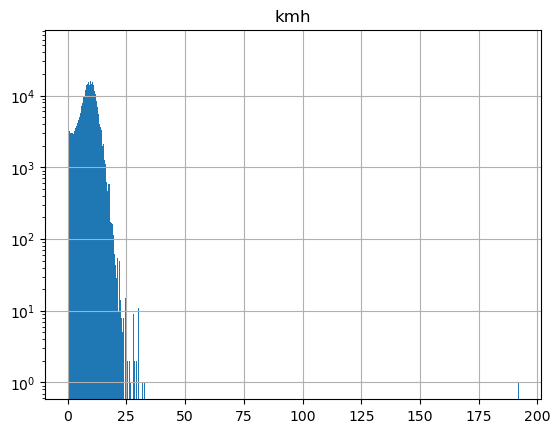

In [90]:
rentals_df.hist(column='kmh',bins=1000, log=True)

Therefore it's not possible to reliably identify outliers. However, according to the graph there are some trips unrealisticly high kmh-values.

In [91]:
rentals_df.loc[rentals_df["kmh"] > 50]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,trip_length,is_roundtrip,start_time_hourly,hour,weekday,weekday_name,month,month_name,season,is_weekend,is_holiday,is_subscription,dist,kmh
268376,2018-06-19 16:37:00,2018-06-19 16:39:00,3184,3188,11891,Day Pass,2,False,2018-06-19 16:00:00,16,1,Tuesday,6,June,Summer,False,False,False,4.931202,147.936059
268379,2018-06-19 16:37:00,2018-06-19 16:39:00,3183,3184,11891,Day Pass,2,False,2018-06-19 16:00:00,16,1,Tuesday,6,June,Summer,False,False,False,6.397954,191.938611
268380,2018-06-19 16:37:00,2018-06-19 16:39:00,3184,3188,11891,Day Pass,2,False,2018-06-19 16:00:00,16,1,Tuesday,6,June,Summer,False,False,False,4.931202,147.936059
268414,2018-06-19 16:47:00,2018-06-19 16:50:00,3186,3185,11891,Day Pass,3,False,2018-06-19 16:00:00,16,1,Tuesday,6,June,Summer,False,False,False,6.610608,132.212154
268419,2018-06-19 16:47:00,2018-06-19 16:50:00,3186,3185,11891,Day Pass,3,False,2018-06-19 16:00:00,16,1,Tuesday,6,June,Summer,False,False,False,6.610608,132.212154
268422,2018-06-19 16:47:00,2018-06-19 16:50:00,3186,3185,11891,Day Pass,3,False,2018-06-19 16:00:00,16,1,Tuesday,6,June,Summer,False,False,False,6.610608,132.212154


These records will be deleted.

In [92]:
rentals_df.drop(rentals_df.loc[rentals_df["kmh"] > 50].index, inplace=True)

## Examination: weather_hourly_philadelphia.csv

Note: No detailed separate examination for all variables is done here as opposed to the rental dataset as all relevant variables need to be examined/manipulated in parallel as visible in the following.

### Preparation steps

Import "philadelphia_2018.csv" dataset with given data types from task PDF:

In [93]:
if EXECUTE_FAILING_CELLS:
    weather_df = pd.read_csv("data/weather_hourly_philadelphia.csv",
                        dtype={"max_temp":"float",
                               "min_temp":"float",
                               "precip":"int"
                              },
                        parse_dates=["date_time"])

ValueError: cannot safely convert passed user dtype of int32 for float64 dtyped data in column 3

Import dataset again with "precip" as float for now as conversion to int fails.

In [94]:
weather_df = pd.read_csv("data/weather_hourly_philadelphia.csv",
                        dtype={"max_temp":"float",
                               "min_temp":"float",
                               "precip":"float" # import as float as conversion to int fails
                              },
                        parse_dates=["date_time"])

In [95]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43848 entries, 0 to 43847
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  43785 non-null  datetime64[ns]
 1   max_temp   43785 non-null  float64       
 2   min_temp   43785 non-null  float64       
 3   precip     43785 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.3 MB


It can be seen that the dataset contains 63 null entries for each column. It seems likely that they make up 63 entire rows with null values, which is verified:

In [96]:
weather_df[weather_df["date_time"].isnull()
           & weather_df["max_temp"].isnull()
           & weather_df["min_temp"].isnull()
           & weather_df["precip"].isnull()]

,date_time,max_temp,min_temp,precip
1104,NaT,NaN,NaN,NaN
1111,NaT,NaN,NaN,NaN
1588,NaT,NaN,NaN,NaN
3973,NaT,NaN,NaN,NaN
4108,NaT,NaN,NaN,NaN
...,...,...,...,...
38638,NaT,NaN,NaN,NaN
41623,NaT,NaN,NaN,NaN
41630,NaT,NaN,NaN,NaN
41744,NaT,NaN,NaN,NaN


As expected, the null values in each column make up 63 entire null rows. Since these contain no data, they will be deleted.

In [97]:
weather_df.dropna(how="all", inplace = True)
weather_df.info() # Verify new row count and null value count

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43785 entries, 0 to 43847
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  43785 non-null  datetime64[ns]
 1   max_temp   43785 non-null  float64       
 2   min_temp   43785 non-null  float64       
 3   precip     43785 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.7 MB


In [98]:
weather_df["precip"].astype(int)

0        0
1        0
2        0
3        0
4        0
        ..
43843    0
43844    0
43845    0
43846    0
43847    0
Name: precip, Length: 43785, dtype: int32

Conversion for "precip" from float64 to int32 finally works.

First of all, the variable "date_time" is reviewed:

In [99]:
weather_df["date_time"].describe(datetime_is_numeric=True)

count                            43785
mean     2017-07-02 08:10:55.539568128
min                2015-01-01 06:00:00
25%                2016-04-01 21:00:00
50%                2017-07-02 02:00:00
75%                2018-10-02 00:00:00
max                2020-01-02 05:00:00
Name: date_time, dtype: object

As it can be seen by the minimum and maximum values, this dataset covers weather data from January 1, 2015 to January 2, 2020.  
Since the main dataset (rental dataset) only includes data for the year of 2018, all other data is deleted as it would be omitted anyway when both datasets are (inner) joined.

In [100]:
weather_df = weather_df.drop(weather_df[(weather_df["date_time"] < pd.to_datetime('2018-01-01')) | (weather_df["date_time"] >= pd.to_datetime('2019-01-01'))].index)

In [101]:
weather_df.sort_values(by="date_time")
weather_df.reset_index(drop = True, inplace = True)
weather_df.info() # Verify new row count and null value count

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8741 entries, 0 to 8740
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  8741 non-null   datetime64[ns]
 1   max_temp   8741 non-null   float64       
 2   min_temp   8741 non-null   float64       
 3   precip     8741 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 273.3 KB


As per dataset description, the weather dataset contains hourly weather data.  
Since the new row count of 8,741 differs from the expected row count of 8,760 rows (365 days in 2018 * 24 hours), it is gonna be verified which hours of the days are missing and if there are any duplicate entries.

In [102]:
# Create DataFrame which includes all hours of all days starting at January 1, 2018 to December 31, 2018.
days = []

current_date = dt.datetime(2018, 1, 1)
while current_date <= dt.datetime(2018, 12, 31):
    for hour in range(24):
        days.append(current_date.strftime(f"%Y-%m-%d {hour}:%M:%S"))
    current_date += dt.timedelta(days=1)
    
calendar_2018_df = pd.DataFrame({'date_time':pd.to_datetime(days)})

calendar_2018_df

,date_time
0,2018-01-01 00:00:00
1,2018-01-01 01:00:00
2,2018-01-01 02:00:00
3,2018-01-01 03:00:00
4,2018-01-01 04:00:00
...,...
8755,2018-12-31 19:00:00
8756,2018-12-31 20:00:00
8757,2018-12-31 21:00:00
8758,2018-12-31 22:00:00


This dataset contains as expected 8,760 rows for all days and all hours.

This dataset will now be joined with the weather dataset by using a left join on the calendar dataset, so that rows with dates, that are found in the calendar dataset but not in the weather dataset, are also included with null values on the weather-specific data.

In [103]:
weather_joined_df = pd.merge(calendar_2018_df, weather_df, on='date_time', how='left').sort_values(by="date_time",ascending=True).sort_index(level=0, ascending=[True])
weather_joined_df

,date_time,max_temp,min_temp,precip
0,2018-01-01 00:00:00,-10.6,-10.6,0.0
1,2018-01-01 01:00:00,-10.6,-10.6,0.0
2,2018-01-01 02:00:00,-11.1,-11.1,0.0
3,2018-01-01 03:00:00,-12.2,-12.2,0.0
4,2018-01-01 04:00:00,-11.7,-11.7,0.0
...,...,...,...,...
9384,2018-12-31 20:00:00,7.2,7.2,1.0
9385,2018-12-31 21:00:00,7.2,7.2,1.0
9386,2018-12-31 21:00:00,6.7,6.7,1.0
9387,2018-12-31 22:00:00,6.1,6.1,1.0


First of all, possible duplicate timestamps are identified.

In [104]:
weather_joined_df_count = weather_joined_df['date_time'].value_counts()

df_filtered_duplicates = weather_df[weather_df["date_time"].isin(weather_joined_df_count[weather_joined_df_count > 1].index)].sort_values(by="date_time")
df_filtered_duplicates

,date_time,max_temp,min_temp,precip
58,2018-01-04 05:00:00,-1.7,-1.7,0.0
83,2018-01-04 05:00:00,-1.7,-2.2,0.0
88,2018-01-04 11:00:00,-4.4,-4.4,0.0
89,2018-01-04 11:00:00,-4.4,-4.4,1.0
94,2018-01-04 17:00:00,-5.6,-5.6,0.0
...,...,...,...,...
8732,2018-12-31 14:00:00,3.9,3.3,0.0
8734,2018-12-31 17:00:00,6.7,6.1,0.0
8735,2018-12-31 17:00:00,7.8,7.8,1.0
8738,2018-12-31 21:00:00,7.2,7.2,1.0


Note: The weather dataset did not contain any null values at the point in time when the left join/merge with the calendar dataset was performed, as the null rows where already deleted in the beginning of the examination of the "date_time" variable.

Now, any missing timestamps in the weather dataset can be identified, since the missing timestamps have been added with null values on the weather data columns due to the left join/merge with the calendar dataset.  

In [105]:
df_filtered_null = weather_joined_df[weather_joined_df['max_temp'].isnull()]
'''
Note: It is sufficient to check only one column on a null value since
all columns will have null values due to the left join which includes
only the missing timestamps in the "date_time"-column from the calendar.
'''
df_filtered_null

,date_time,max_temp,min_temp,precip
83,2018-01-04 10:00:00,NaN,NaN,NaN
88,2018-01-04 14:00:00,NaN,NaN,NaN
95,2018-01-04 20:00:00,NaN,NaN,NaN
98,2018-01-04 22:00:00,NaN,NaN,NaN
197,2018-01-09 00:00:00,NaN,NaN,NaN
...,...,...,...,...
9325,2018-12-29 12:00:00,NaN,NaN,NaN
9373,2018-12-31 11:00:00,NaN,NaN,NaN
9378,2018-12-31 15:00:00,NaN,NaN,NaN
9382,2018-12-31 18:00:00,NaN,NaN,NaN


One interesting observation can be already made by just looking at the preview of the datasets: The records can be lined up/sorted in chronological order by picking...

- two records from the duplicate dataset (2018-01-04 05:00:00)
- one record from the null value dataset (2018-01-04 10:00:00)
- the next two records from the duplicate dataset (2018-01-04 11:00:00)
- the next one record from the null value dataset (2018-01-04 14:00:00)
- the next two records from the duplicate dataset (2018-01-04 17:00:00)

and so on.

The reason for the duplicates and the null values might be that the records were not captured exactly when a new hour started (= {HH}:00:00 as record, with HH as respective hour), but maybe some seconds after (e.g. {HH}:00:04) or some seconds before (e.g. {HH}-1:00:57) a new hour.  

Example:

- Duplicate values occur when e.g. data for hour 10 is recorded at 10:00:05 and data for hour 11 is recorded at 10:59:59
- This can automatically lead to null values for hour 11, because data for hour 12 may be recorded correctly at 12:00:04

| hour      | timestamp | timestamp (min/sec truncated) |
| ----------- | ----------- | ----------- |
| 10 | 10:00:05 | 10:00:00 |
| 11 | 10:59:59 | 10:00:00 |
| 12 | 12:00:04 | 12:00:00 |

This theory can't be finally verified since the minutes and seconds are truncated in the weather dataset and no more granular data showing these values is available.  But as a consequence for handling these rows, it would be necessary to shift the duplicate timestamp for 10:00:00 by one hour to 11:00:00.

This could be the basis for a reliable approach for handling the duplicate-timestamp rows and null-value rows and the theory is therefore examined further in the following steps.   

For that, first of all a dataset that concatenates both datasets and orders them in chronological order is created.

In [106]:
df_filtered_all = pd.concat([df_filtered_null, df_filtered_duplicates], axis=0).sort_values(by="date_time")

In [107]:
df_filtered_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1906 entries, 58 to 9388
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  1906 non-null   datetime64[ns]
 1   max_temp   1258 non-null   float64       
 2   min_temp   1258 non-null   float64       
 3   precip     1258 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 74.5 KB


In [108]:
# Adjust row display to row count of dataframe
pd.options.display.max_rows = df_filtered_all.shape[0]
df_filtered_all

,date_time,max_temp,min_temp,precip
58,2018-01-04 05:00:00,-1.7,-1.7,0.0
83,2018-01-04 05:00:00,-1.7,-2.2,0.0
83,2018-01-04 10:00:00,NaN,NaN,NaN
88,2018-01-04 11:00:00,-4.4,-4.4,0.0
89,2018-01-04 11:00:00,-4.4,-4.4,1.0
88,2018-01-04 14:00:00,NaN,NaN,NaN
94,2018-01-04 17:00:00,-5.6,-5.6,0.0
95,2018-01-04 17:00:00,-5.0,-5.6,0.0
95,2018-01-04 20:00:00,NaN,NaN,NaN
98,2018-01-04 21:00:00,-3.9,-3.9,0.0


The described pattern above of three associated rows (two duplicate-timestamp rows and one null-value row which is the result of inaccurately recorded timestamps) is now visible in a large dimension which provides an indication that the described theory is true.  

Nevertheless, some records are "outliers" in terms of that they don't follow this pattern which can be seen by scrolling through the dataset but also in the dataset info: 1906 total row count, but 1258 null-rows. In theory, the ratio would need to be 3:1.  

Since they need to be treated differently than the associated duplicate-timestamp rows and null-value rows, the dataset will be split up accordingly.  

Two new DataFrames for each case are therefore created, "weather_df_associated_rows" which contains all rows following the described pattern (duplicate-timestamp rows with a single following null-row) and "weather_df_null_rows" which contains all null-value rows that are not following this pattern, i.e. can't be associated with duplicate-timestamp rows.

In [109]:
weather_df_null_rows = pd.DataFrame(columns=["date_time", "max_temp", "min_temp", "precip"])
weather_df_associated_rows = pd.DataFrame(columns=["date_time", "max_temp", "min_temp", "precip"])

weather_df_null_rows = weather_df_null_rows.astype(dtype= {"date_time": "datetime64", "max_temp": "float64", "min_temp": "float64", "precip": "float64"})
weather_df_associated_rows = weather_df_associated_rows.astype(dtype= {"date_time": "datetime64", "max_temp": "float64", "min_temp": "float64", "precip": "float64"})

weather_df_null_rows.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  0 non-null      datetime64[ns]
 1   max_temp   0 non-null      float64       
 2   min_temp   0 non-null      float64       
 3   precip     0 non-null      float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 0.0+ bytes


Now, the associated rows and null rows will be separated:

In [110]:
# Reset index for the entire filtered dataset
df_filtered_all.reset_index(drop = True, inplace = True)

# Introduce counter, named "index"
index = 0
# While: Counter "index" is still in range of rows
while index < df_filtered_all.shape[0]-1:
    
    # If: First two rows have the same date (duplicate rows) and third row is null (null row) => Add to associated rows dataset
    if df_filtered_all.loc[index, "date_time"] == df_filtered_all.loc[index+1, "date_time"] and df_filtered_all["max_temp"].isnull()[index+2]:
        print(index, df_filtered_all.loc[index, "date_time"], df_filtered_all.loc[index+2, "date_time"])
        weather_df_associated_rows.loc[len(weather_df_associated_rows)] = df_filtered_all.loc[index].values.flatten().tolist()
        weather_df_associated_rows.loc[len(weather_df_associated_rows)] = df_filtered_all.loc[index+1].values.flatten().tolist()
        weather_df_associated_rows.loc[len(weather_df_associated_rows)] = df_filtered_all.loc[index+2].values.flatten().tolist()
        # Move index up by 3 to go to the next group
        index += 3
        
    # Else: Add to null rows dataset, since this row doesn't belong to an associated rows-pair
    else:
        while df_filtered_all.loc[index, "date_time"] != df_filtered_all.loc[index+1, "date_time"]:
            print(index, "WARNING SINGLE NULL ROW!", df_filtered_all.loc[index, "date_time"], df_filtered_all.loc[index+1, "date_time"])
            weather_df_null_rows.loc[len(weather_df_null_rows)] = df_filtered_all.loc[index].values.flatten().tolist()
            # Move index up only by 1, since the next row could be again a associated row-pair
            index += 1

0 2018-01-04 05:00:00 2018-01-04 10:00:00
3 2018-01-04 11:00:00 2018-01-04 14:00:00
6 2018-01-04 17:00:00 2018-01-04 20:00:00
9 2018-01-04 21:00:00 2018-01-04 22:00:00
12 2018-01-08 23:00:00 2018-01-09 00:00:00
15 2018-01-09 01:00:00 2018-01-09 05:00:00
18 2018-01-09 07:00:00 2018-01-09 08:00:00
21 2018-01-09 11:00:00 2018-01-09 12:00:00
24 2018-01-12 10:00:00 2018-01-12 12:00:00
27 2018-01-12 13:00:00 2018-01-12 15:00:00
30 2018-01-12 17:00:00 2018-01-12 20:00:00
33 2018-01-12 22:00:00 2018-01-13 02:00:00
36 2018-01-13 05:00:00 2018-01-13 07:00:00
39 2018-01-13 11:00:00 2018-01-13 12:00:00
42 2018-01-15 11:00:00 2018-01-15 12:00:00
45 2018-01-15 17:00:00 2018-01-15 18:00:00
48 2018-01-16 08:00:00 2018-01-16 09:00:00
51 2018-01-16 12:00:00 2018-01-16 14:00:00
54 2018-01-16 21:00:00 2018-01-16 22:00:00
57 2018-01-17 01:00:00 2018-01-17 02:00:00
60 2018-01-17 04:00:00 2018-01-17 05:00:00
63 2018-01-17 06:00:00 2018-01-17 08:00:00
66 2018-01-17 09:00:00 2018-01-17 12:00:00
69 2018-01-17 1

558 2018-05-12 15:00:00 2018-05-12 16:00:00
561 2018-05-12 19:00:00 2018-05-12 20:00:00
564 2018-05-12 23:00:00 2018-05-13 03:00:00
567 2018-05-13 07:00:00 2018-05-13 09:00:00
570 2018-05-13 14:00:00 2018-05-13 16:00:00
573 2018-05-13 17:00:00 2018-05-13 18:00:00
576 2018-05-14 00:00:00 2018-05-14 01:00:00
579 2018-05-14 02:00:00 2018-05-14 05:00:00
582 2018-05-14 06:00:00 2018-05-14 08:00:00
585 2018-05-14 10:00:00 2018-05-14 11:00:00
588 2018-05-14 13:00:00 2018-05-14 14:00:00
591 2018-05-14 17:00:00 2018-05-14 18:00:00
594 2018-05-15 04:00:00 2018-05-15 06:00:00
597 2018-05-15 07:00:00 2018-05-15 08:00:00
600 2018-05-15 10:00:00 2018-05-15 11:00:00
603 2018-05-15 22:00:00 2018-05-16 01:00:00
606 2018-05-16 03:00:00 2018-05-16 04:00:00
609 2018-05-16 07:00:00 2018-05-16 08:00:00
612 2018-05-16 09:00:00 2018-05-16 10:00:00
615 2018-05-16 12:00:00 2018-05-16 14:00:00
618 2018-05-17 07:00:00 2018-05-17 09:00:00
621 2018-05-17 10:00:00 2018-05-17 11:00:00
624 2018-05-17 12:00:00 2018-05-

1128 2018-08-18 21:00:00 2018-08-18 22:00:00
1131 2018-08-19 14:00:00 2018-08-19 18:00:00
1134 2018-08-19 20:00:00 2018-08-19 21:00:00
1137 2018-08-19 22:00:00 2018-08-20 01:00:00
1140 2018-08-20 02:00:00 2018-08-20 03:00:00
1143 2018-08-20 04:00:00 2018-08-20 05:00:00
1146 2018-08-21 12:00:00 2018-08-21 14:00:00
1149 2018-08-21 15:00:00 2018-08-21 17:00:00
1152 2018-08-21 18:00:00 2018-08-21 19:00:00
1155 2018-08-21 22:00:00 2018-08-21 23:00:00
1158 2018-08-22 01:00:00 2018-08-22 08:00:00
1161 2018-08-22 10:00:00 2018-08-22 12:00:00
1164 2018-08-22 14:00:00 2018-08-22 15:00:00
1167 WARNING SINGLE NULL ROW! 2018-08-25 08:00:00 2018-08-25 09:00:00
1168 WARNING SINGLE NULL ROW! 2018-08-25 09:00:00 2018-08-25 10:00:00
1169 WARNING SINGLE NULL ROW! 2018-08-25 10:00:00 2018-08-25 11:00:00
1170 WARNING SINGLE NULL ROW! 2018-08-25 11:00:00 2018-08-25 12:00:00
1171 WARNING SINGLE NULL ROW! 2018-08-25 12:00:00 2018-08-28 03:00:00
1172 2018-08-28 03:00:00 2018-08-28 04:00:00
1175 2018-08-28 09:0

1717 2018-11-24 12:00:00 2018-11-24 13:00:00
1720 2018-11-24 17:00:00 2018-11-24 18:00:00
1723 2018-11-24 20:00:00 2018-11-24 22:00:00
1726 2018-11-24 23:00:00 2018-11-25 01:00:00
1729 2018-11-25 02:00:00 2018-11-25 03:00:00
1732 2018-11-26 03:00:00 2018-11-26 04:00:00
1735 2018-11-26 17:00:00 2018-11-26 19:00:00
1738 2018-11-26 20:00:00 2018-11-26 23:00:00
1741 2018-11-27 00:00:00 2018-11-27 02:00:00
1744 2018-11-27 04:00:00 2018-11-27 05:00:00
1747 2018-12-01 10:00:00 2018-12-01 11:00:00
1750 2018-12-01 14:00:00 2018-12-01 15:00:00
1753 2018-12-01 20:00:00 2018-12-02 02:00:00
1756 2018-12-02 04:00:00 2018-12-02 05:00:00
1759 2018-12-02 07:00:00 2018-12-02 08:00:00
1762 2018-12-02 14:00:00 2018-12-02 19:00:00
1765 2018-12-02 21:00:00 2018-12-03 00:00:00
1768 2018-12-03 01:00:00 2018-12-03 03:00:00
1771 2018-12-03 05:00:00 2018-12-03 06:00:00
1774 2018-12-03 07:00:00 2018-12-03 09:00:00
1777 2018-12-05 15:00:00 2018-12-05 18:00:00
1780 2018-12-05 19:00:00 2018-12-05 21:00:00
1783 2018-

In [111]:
weather_df_null_rows

,date_time,max_temp,min_temp,precip
0,2018-04-11 04:00:00,NaT,NaT,NaT
1,2018-04-11 05:00:00,NaT,NaT,NaT
2,2018-05-09 05:00:00,NaT,NaT,NaT
3,2018-05-09 06:00:00,NaT,NaT,NaT
4,2018-05-09 07:00:00,NaT,NaT,NaT
5,2018-05-10 05:00:00,NaT,NaT,NaT
6,2018-06-12 08:00:00,NaT,NaT,NaT
7,2018-08-11 08:00:00,NaT,NaT,NaT
8,2018-08-11 09:00:00,NaT,NaT,NaT
9,2018-08-11 10:00:00,NaT,NaT,NaT


In [112]:
weather_df_associated_rows

,date_time,max_temp,min_temp,precip
0,2018-01-04 05:00:00,-1.7,-1.7,0.0
1,2018-01-04 05:00:00,-1.7,-2.2,0.0
2,2018-01-04 10:00:00,NaT,NaT,NaT
3,2018-01-04 11:00:00,-4.4,-4.4,0.0
4,2018-01-04 11:00:00,-4.4,-4.4,1.0
5,2018-01-04 14:00:00,NaN,NaN,NaN
6,2018-01-04 17:00:00,-5.6,-5.6,0.0
7,2018-01-04 17:00:00,-5.0,-5.6,0.0
8,2018-01-04 20:00:00,NaN,NaN,NaN
9,2018-01-04 21:00:00,-3.9,-3.9,0.0


Now, the time delta between the null-value and duplicated rows will be examined:

In [113]:
# Create empty array for storing the values
weather_df_associated_rows_time_difference = np.empty(0, dtype=int)

# Calculate time delta in hours for null-value and the duplicated rows by subtracting "date_time"
for index in list(range(len(weather_df_associated_rows)))[0::3]:
    weather_df_associated_rows_time_difference = np.append(weather_df_associated_rows_time_difference, int((weather_df_associated_rows.loc[index+2, "date_time"]-weather_df_associated_rows.loc[index, "date_time"]).total_seconds() / 3600))

# Prepare counts for x- and y-axis separately
unique, counts = np.unique(weather_df_associated_rows_time_difference, return_counts=True)

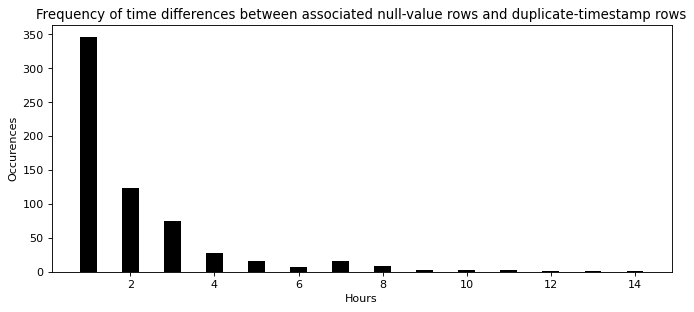

In [114]:
# Setup plot
fig = plt.figure(figsize = (10, 4), dpi = 80)

# Display plot
plt.bar(unique, counts, width = 0.4, color = "black")
 
plt.xlabel("Hours")
plt.ylabel("Occurences")
plt.title("Frequency of time differences between associated null-value rows and duplicate-timestamp rows")
plt.show()

It can be seen that the vast majority of the associated pairs of null-value rows and duplicate-timestamp rows have a delta of 1 to 3 hours. This and also the fact that there is no negative difference between the rows (hours have values of >= 1) strengthens the explained theory that the timestamps were recorded a few seconds before the actual hour started.  

As a consequence for handling the duplicate-timestamp and null-value rows, all rows starting with the duplicate-timestamp row will be shifted by one hour to the future until the associated null-value row is reached and filled.  

Example of original data:

| timestamp | measurement |
| ----------- | ----------- |
| 10:00:00 | 10 |
| 10:00:00 (dup) | 20 |
| 11:00:00 | 30 |
| 12:00:00 | 40 |
| 13:00:00 | null |

Example of modified data:

| timestamp | measurement |
| ----------- | ----------- |
| 10:00:00 | 10 |
| ~~10:00:00 (dup)~~ | ~~20~~ |
| 11:00:00 | 20 |
| 12:00:00 | 30 |
| 13:00:00 | 40 |

Exemplary verification of the associated duplicate-timestamp rows 2018-02-21 05:00:00 and null-value row 2018-02-21 12:00:00 before data handling:

In [115]:
weather_joined_df.loc[(weather_joined_df["date_time"] >= pd.to_datetime('2018-02-21 05:00:00')) & (weather_joined_df["date_time"] <= pd.to_datetime('2018-02-21 12:00:00'))]

,date_time,max_temp,min_temp,precip
1309,2018-02-21 05:00:00,14.4,14.4,0.0
1310,2018-02-21 05:00:00,15.0,14.4,0.0
1311,2018-02-21 06:00:00,13.9,13.9,0.0
1312,2018-02-21 07:00:00,14.4,13.9,0.0
1313,2018-02-21 08:00:00,13.9,13.3,0.0
1314,2018-02-21 09:00:00,11.7,11.1,0.0
1315,2018-02-21 10:00:00,12.2,11.7,0.0
1316,2018-02-21 11:00:00,15.0,13.3,0.0
1317,2018-02-21 12:00:00,NaN,NaN,NaN


In [116]:
for index in list(range(len(weather_df_associated_rows)))[0::3]:
    # Get current duplicate row
    dup_dt = weather_df_associated_rows.loc[index, "date_time"]
    
    # Get current null-value row (by index+2 because index+1 is the duplicated row)
    null_val_dt = weather_df_associated_rows.loc[index+2, "date_time"]
    
    # Get indexes of both dataframes for iterating over the weather dataset in the next step
    dup_dt_index = weather_joined_df.index[weather_joined_df["date_time"] == dup_dt][-1] 
    null_val_index = weather_joined_df.index[weather_joined_df["date_time"] == null_val_dt].item()
    
    # Get size of the null values dataframe for iterating over the weather dataset in the next step
    index_counter = null_val_index-1
    
    while index_counter >= dup_dt_index:
        # Shift values back by 1 index/1 row and therefore overwriting the second duplicate (which is at position index_counter+1)
        weather_joined_df.loc[index_counter+1, "max_temp"] = weather_joined_df.loc[index_counter, "max_temp"]
        weather_joined_df.loc[index_counter+1, "min_temp"] = weather_joined_df.loc[index_counter, "min_temp"]
        weather_joined_df.loc[index_counter+1, "precip"] = weather_joined_df.loc[index_counter, "precip"]
        index_counter -= 1
    
    # Delete duplicate by using the calculated index
    weather_joined_df.drop(dup_dt_index, inplace = True)

Verification of the example after data handling:

In [117]:
weather_joined_df.loc[(weather_joined_df["date_time"] >= pd.to_datetime('2018-02-21 05:00:00')) & (weather_joined_df["date_time"] <= pd.to_datetime('2018-02-21 12:00:00'))]

,date_time,max_temp,min_temp,precip
1309,2018-02-21 05:00:00,14.4,14.4,0.0
1311,2018-02-21 06:00:00,15.0,14.4,0.0
1312,2018-02-21 07:00:00,13.9,13.9,0.0
1313,2018-02-21 08:00:00,14.4,13.9,0.0
1314,2018-02-21 09:00:00,13.9,13.3,0.0
1315,2018-02-21 10:00:00,11.7,11.1,0.0
1316,2018-02-21 11:00:00,12.2,11.7,0.0
1317,2018-02-21 12:00:00,15.0,13.3,0.0


It can be seen that the data handling works as expected when compared to the sample before the handling:  
All rows starting at the duplicate-value row of timestamp "2018-02-21 05:00:00" are shifted by one hour towards the null-value row of timestamp "2018-02-21 12:00:00". The duplicated-value row is deleted after the operation.

In [118]:
weather_joined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 9388
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  8760 non-null   datetime64[ns]
 1   max_temp   8741 non-null   float64       
 2   min_temp   8741 non-null   float64       
 3   precip     8741 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 342.2 KB


New row count of the weather dataset is 8,760 as expected: 365 days * 24h = 8,760 without any duplicates.  
Finally, the 19 null-value rows, that are not associated with any duplicate-timestamp rows, need to be treated.  
These are the ones that have been separated into the "weather_df_null_rows"-dataset before.

In [119]:
weather_df_null_rows

,date_time,max_temp,min_temp,precip
0,2018-04-11 04:00:00,NaT,NaT,NaT
1,2018-04-11 05:00:00,NaT,NaT,NaT
2,2018-05-09 05:00:00,NaT,NaT,NaT
3,2018-05-09 06:00:00,NaT,NaT,NaT
4,2018-05-09 07:00:00,NaT,NaT,NaT
5,2018-05-10 05:00:00,NaT,NaT,NaT
6,2018-06-12 08:00:00,NaT,NaT,NaT
7,2018-08-11 08:00:00,NaT,NaT,NaT
8,2018-08-11 09:00:00,NaT,NaT,NaT
9,2018-08-11 10:00:00,NaT,NaT,NaT


It is visible that there are values missing for single timestamps as well as for groups of adjacent timestamps.  
It is therefore decided to linearly interpolate the values by using the next available timestamps at the lower and upper boundary rather than just impute fixed values like the mean, because it is more likely that the temperature is rising/lowering (depending on the boundary values) across the time rather than staying fixed over all the time and suddenly jumping to a higher/lower boundary value.  

Filling in missing values for precipitation is more difficult in contrast since it only describes if it was raining to that point in time and it could for sure suddenly start/stop to rain (again).  However, since it is not possible to make detailed assumption, the precipitation will also be linearly interploated.

Example for 2018-05-09 04:00:00 to 2018-05-09 08:00:00:

In [120]:
# Used indexes retrieved manually by searching through the weather dataset and using the known dates for null values from the log above
print(weather_joined_df.loc[[3253,3254,3255,3256,3257]])

               date_time  max_temp  min_temp  precip
3253 2018-05-09 04:00:00      13.3      13.3     0.0
3254 2018-05-09 05:00:00       NaN       NaN     NaN
3255 2018-05-09 06:00:00       NaN       NaN     NaN
3256 2018-05-09 07:00:00       NaN       NaN     NaN
3257 2018-05-09 08:00:00      12.2      12.2     0.0


In [121]:
weather_joined_df[["max_temp", "min_temp", "precip"]] = weather_joined_df[["max_temp", "min_temp", "precip"]].interpolate()

In [122]:
# Review values
print(weather_joined_df.loc[[3253,3254,3255,3256,3257]])

               date_time  max_temp  min_temp  precip
3253 2018-05-09 04:00:00    13.300    13.300     0.0
3254 2018-05-09 05:00:00    13.025    13.025     0.0
3255 2018-05-09 06:00:00    12.750    12.750     0.0
3256 2018-05-09 07:00:00    12.475    12.475     0.0
3257 2018-05-09 08:00:00    12.200    12.200     0.0


In [123]:
# Round temperatures to one decimal place
weather_joined_df[["max_temp", "min_temp"]] = weather_joined_df[["max_temp", "min_temp"]].round(1)

In [124]:
# Review values
print(weather_joined_df.loc[[3253,3254,3255,3256,3257]])

               date_time  max_temp  min_temp  precip
3253 2018-05-09 04:00:00      13.3      13.3     0.0
3254 2018-05-09 05:00:00      13.0      13.0     0.0
3255 2018-05-09 06:00:00      12.8      12.8     0.0
3256 2018-05-09 07:00:00      12.5      12.5     0.0
3257 2018-05-09 08:00:00      12.2      12.2     0.0


It is also investigated if the "0"-values of "max_temp" and "min_temp" are true zero values or respresenting erroneous values, i.e. no measurements are available for the respective point in time.  
The same can't be reliably checked for precipitation "precip" as there are only 0/1-values and an overrepresentation of zeroes might be just the natural consequence of the recorded weather.  

Therefore, all pairs of "max_temp" and "min_temp" that have the same value are verfified for their absolute frequency in the dataset:

In [125]:
weather_value_pairs_df = weather_joined_df[["max_temp","min_temp"]][abs(weather_joined_df["max_temp"])-abs(weather_joined_df["min_temp"]) == 0]#.drop_duplicates()
weather_value_pairs_df = weather_value_pairs_df.groupby(["max_temp","min_temp"]).size().reset_index(name='Count').sort_values("Count")

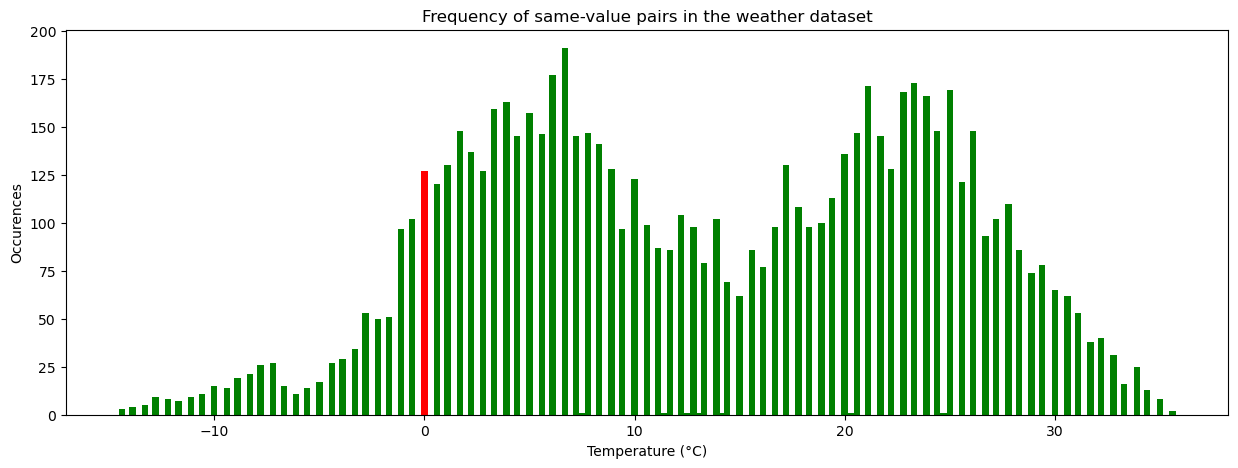

In [126]:
# Setup plot
fig = plt.figure(figsize = (15, 5), dpi = 100)
 
temp = weather_value_pairs_df["max_temp"]
count = weather_value_pairs_df["Count"]    

# Display bar plot
plt.bar(temp, count, width = 0.3, color = ["green" if i != 0 else "red" for i in temp])
 
plt.xlabel("Temperature (°C)")
plt.ylabel("Occurences")
plt.title("Frequency of same-value pairs in the weather dataset")
plt.show()

It can be seen that the "0"-value-pairs are not overrepresented and therefore there is no further need in treatment.

Finally, "min_temp" and "max_temp" will be merged by calculating the average of both. The reason is that very high changes are unplausible within the same hour and it is assumed that a difference doesn't affect the demand for trips overall.  
However, those differences will be reviewed:

Text(0.5, 1.0, 'Difference between min_temp and max_temp')

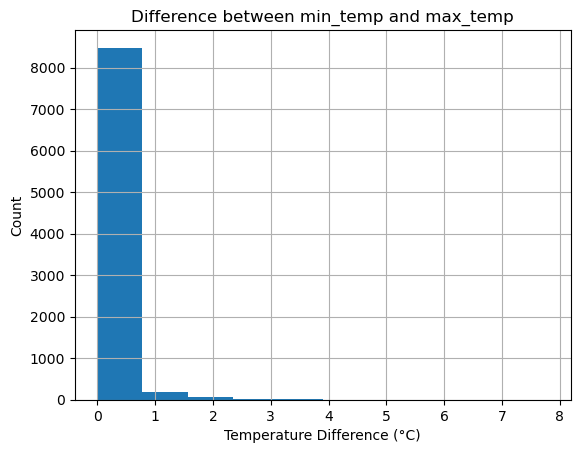

In [127]:
ax = (weather_joined_df["max_temp"] - weather_joined_df["min_temp"]).hist()

ax.set_xlabel("Temperature Difference (°C)")
ax.set_ylabel("Count")
ax.set_title("Difference between min_temp and max_temp")

As expected, the differences are insignificant and as explained, the columns will be merged:

In [128]:
# Calculate average and round to one decimal
weather_joined_df["temp"] = ((weather_joined_df["max_temp"] + weather_joined_df["min_temp"])/2).round(1)
weather_joined_df.drop(columns=["min_temp", "max_temp"], inplace = True)

In [129]:
# Verification
weather_joined_df["temp"].head(50)

0    -10.6
1    -10.6
2    -11.1
3    -12.2
4    -11.7
5    -11.7
6    -12.2
7    -12.8
8    -12.2
9    -12.8
10   -12.8
11   -12.8
12   -13.9
13   -13.3
14   -12.2
15   -10.6
16    -9.4
17    -8.3
18    -7.2
19    -7.2
20    -7.2
21    -7.2
22    -7.8
23    -7.8
24    -7.8
25    -8.9
26    -8.3
27    -8.9
28    -9.4
29    -9.4
30    -9.4
31   -10.0
32   -10.0
33   -10.6
34   -10.6
35   -10.6
36   -10.0
37   -10.0
38    -8.9
39    -7.2
40    -6.7
41    -5.6
42    -5.0
43    -4.4
44    -4.4
45    -4.4
46    -5.0
47    -5.6
48    -5.6
49    -6.1
Name: temp, dtype: float64

In [130]:
weather_joined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 9388
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  8760 non-null   datetime64[ns]
 1   precip     8760 non-null   float64       
 2   temp       8760 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 531.8 KB


Row count of 8,760 with all columns non-null.

---

Finally, as a result of the data preparation task, the prepared datasets are exported as CSV and can be used for the further tasks.

In [131]:
# Uncomment to overwrite

#rentals_df.to_csv("data_prepared/rentals.csv", sep=",", encoding="utf-8", index=False)
#weather_joined_df.to_csv("data_prepared/weather.csv", sep=",", encoding="utf-8", index=False)
#stations_df.to_csv("data_prepared/stations.csv", sep=",", encoding="utf-8", index=False)